<a href="https://colab.research.google.com/github/josbex/HS-detection_in_social_media_posts/blob/master/Interpretation_of_BERT_using_captum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interpretation of BertForSequenceClassification in captum

The orignial notebook this is based on can be found here:
https://colab.research.google.com/drive/1Lw3JTZio03VwPvSVFzLJmZ52oBRpo9ZM 

In [1]:
# Install dependencies
!pip install transformers
!pip install captum

     |████████████████████████████████| 778kB 3.5MB/s 
     |████████████████████████████████| 890kB 18.4MB/s 
     |████████████████████████████████| 1.1MB 28.8MB/s 
     |████████████████████████████████| 3.0MB 30.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=55fd75d538ec34734e9a33af1c2317004cdedd67648cc6b435eb08fa62022f60
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 1.4MB 3.5MB/s 


In [2]:
import captum
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from captum.attr import visualization as viz
from captum.attr import IntegratedGradients, LayerConductance, LayerIntegratedGradients
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer
import torch
import matplotlib.pyplot as plt
from matplotlib.widgets import TextBox

In [3]:
import pandas as pd
import numpy as np
import csv

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [6]:
# Load a trained model and vocabulary that you have fine-tuned
def load_model(dir):
  output_dir = "./gdrive/My Drive/thesis/model/" + dir
  model = BertForSequenceClassification.from_pretrained(output_dir, output_attentions=True)
  tokenizer = BertTokenizer.from_pretrained(output_dir)
  # Copy the model to the GPU.
  model.to(device)
  model.eval()
  model.zero_grad()
  return model, tokenizer

In [7]:
# load model and tokenizer
#model, tokenizer = load_model("/learn_rate_5/model_save") # model with 0.827 f1 score
model, tokenizer = load_model("new_training_round/best_model/model_save") # model with 0.819 f1 score

In [8]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [9]:
def predict(inputs):
    #print('model(inputs): ', model(inputs))
    return model(inputs)[0]

In [10]:
ref_token_id = tokenizer.pad_token_id # A token used for generating token reference
sep_token_id = tokenizer.sep_token_id # A token used as a separator between question and text and it is also added to the end of the text.
cls_token_id = tokenizer.cls_token_id # A token used for prepending to the concatenated question-text word sequence

In [11]:
def construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id):
    text_ids = tokenizer.encode(text, add_special_tokens=False)
    # construct input token ids
    input_ids = [cls_token_id] + text_ids + [sep_token_id]
    # construct reference token ids 
    ref_input_ids = [cls_token_id] + [ref_token_id] * len(text_ids) + [sep_token_id]

    return torch.tensor([input_ids], device=device), torch.tensor([ref_input_ids], device=device), len(text_ids)

def construct_input_ref_token_type_pair(input_ids, sep_ind=0):
    seq_len = input_ids.size(1)
    token_type_ids = torch.tensor([[0 if i <= sep_ind else 1 for i in range(seq_len)]], device=device)
    ref_token_type_ids = torch.zeros_like(token_type_ids, device=device)# * -1
    return token_type_ids, ref_token_type_ids

def construct_input_ref_pos_id_pair(input_ids):
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
    # we could potentially also use random permutation with `torch.randperm(seq_length, device=device)`
    ref_position_ids = torch.zeros(seq_length, dtype=torch.long, device=device)

    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
    ref_position_ids = ref_position_ids.unsqueeze(0).expand_as(input_ids)
    return position_ids, ref_position_ids
    
def construct_attention_mask(input_ids):
    return torch.ones_like(input_ids)

In [12]:
def custom_forward(inputs):
    preds = predict(inputs)
    #return torch.softmax(preds, dim = 1)[:, 0] # for negative attribution, 
    return torch.softmax(preds, dim = 1)[:, 1] #<- for positive attribution

In [13]:
lig = LayerIntegratedGradients(custom_forward, model.bert.embeddings)

In [14]:
def get_dataset(filename):
  df = pd.read_csv("/content/gdrive/My Drive/thesis/" + filename + ".tsv", sep="\t") 
  return df

In [15]:
def get_test_tweet_by_index(index):
  df = get_dataset("dataset/test_data")
  tweets = df.tweet.values
  labels = df.label.values
  print("tweet: " + str(tweets[index]) + " label: " + str(labels[index]))
  return tweets[index], labels[index]

def get_prediction_type_indices(df):
  tp_indices = df.loc[df['Type'] == 'tp'].Index.values
  tn_indices = df.loc[df['Type'] == 'tn'].Index.values
  fp_indices = df.loc[df['Type'] == 'fp'].Index.values
  fn_indices = df.loc[df['Type'] == 'fn'].Index.values
  return tp_indices, tn_indices, fp_indices, fn_indices

In [16]:
def tokenize_tweet(tweet):
  input_ids, ref_input_ids, sep_id = construct_input_ref_pair(tweet, ref_token_id, sep_token_id, cls_token_id)
  token_type_ids, ref_token_type_ids = construct_input_ref_token_type_pair(input_ids, sep_id)
  position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
  attention_mask = construct_attention_mask(input_ids)
  indices = input_ids[0].detach().tolist()
  all_tokens = tokenizer.convert_ids_to_tokens(indices)
  return input_ids, ref_input_ids, sep_id, token_type_ids, ref_token_type_ids, position_ids, ref_position_ids, attention_mask, indices, all_tokens

In [17]:
df = get_dataset("model/predictions/pred_indices")
tp_indices, tn_indices, fp_indices, fn_indices = get_prediction_type_indices(df)

In [18]:
def get_attributions(input_ids, ref_input_ids):
  attributions, delta = lig.attribute(inputs=input_ids,
                                    baselines=ref_input_ids,
                                    n_steps=7000,
                                    internal_batch_size=5,
                                    return_convergence_delta=True)
  return attributions, delta

In [19]:
def print_tweet_with_prediction(tweet, score):
  print('Tweet: ', tweet)
  print('Sentiment: ' + str(torch.argmax(score[0]).cpu().numpy()) + \
        ', Probability positive: ' + str(torch.softmax(score, dim = 1)[0][1].cpu().detach().numpy()))

In [20]:
def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    return attributions

In [21]:
def save_vis(attributions_sum, score, true_label, tweet, all_tokens, delta):
  # storing couple samples in an array for visualization purposes
  score_vis = viz.VisualizationDataRecord(attributions_sum,
                                          torch.softmax(score, dim = 1)[0][0],
                                          torch.argmax(torch.softmax(score, dim = 1)[0]),
                                          true_label,
                                          tweet,
                                          attributions_sum.sum(),       
                                          all_tokens,
                                          delta)
  return score_vis

In [22]:
print('fp: ' + str(len(fp_indices)))
print('tp: ' + str(len(tp_indices)))
print('fn: ' + str(len(fn_indices)))
print('tn: ' + str(len(tn_indices)))

fp: 57
tp: 172
fn: 68
tn: 563


##Plot attributions

In [26]:
def get_attribution_per_token(all_tokens, attributions_sum, index):
  return all_tokens[index], attributions_sum[index]

def get_nth_top_tokens(n, attributions_sum):
  lst = pd.Series(attributions_sum)
  i = lst.nlargest(n)
  return i.index.values.tolist()

def get_nth_bottom_tokens(n, attributions_sum):
  lst = pd.Series(attributions_sum)
  i = lst.nsmallest(n)
  return i.index.values.tolist()

def get_negative_attributions(attribution_sum, token_indices):
  negative_indices = []
  for i in token_indices:
    if(attribution_sum[i] < 0):
      negative_indices.append(i)
  return negative_indices

def get_positive_attributions(attribution_sum, token_indices):
  positive_indices = []
  for i in token_indices:
    if(attribution_sum[i] > 0):
      positive_indices.append(i)
  return positive_indices

def get_n_attributions_and_tokens(n, attributions_sum, all_tokens):
  n_attributions = []
  n_tokens = []
  n_top_tokens = get_nth_top_tokens(n, attributions_sum)
  n_top_tokens = get_positive_attributions(attributions_sum, n_top_tokens)
  nr_of_top_tokens = len(n_top_tokens)
  n_bottom_tokens = get_nth_bottom_tokens(n, attributions_sum)
  n_bottom_tokens = get_negative_attributions(attributions_sum, n_bottom_tokens)
  n_top_tokens.extend(n_bottom_tokens) #Save all indices we need in one list
  for i in n_top_tokens:
    n_attributions.append(attributions_sum[i])
    n_tokens.append(all_tokens[i])
  return n_attributions, n_tokens, nr_of_top_tokens

def get_colors(n, n_attributions, c1, c2):
  col = []
  for i in range(len(n_attributions)):
    if i < n:
      col.append(c1)
    else:
      col.append(c2)
  return col

In [24]:
def plot_top_attributions(n, n_attributions, n_tokens, ylabel, title, name):
  fig = plt.figure(figsize=(19.20,10.80))
  index = np.arange(len(n_tokens))
  col = get_colors(n, n_attributions, 'grey', 'black')
  bars = plt.bar(index, n_attributions, color = col)
  plt.axhline(y=0,linewidth=2, color='k')
  plt.ylabel(ylabel, fontsize=16)
  plt.xticks(index, n_tokens, fontsize=16, rotation=90)
  plt.title(title, fontsize=22)
  plt.show()
  fig.savefig("/content/gdrive/My Drive/thesis/interpret_plots/" + name + ".pdf")

tweet: rap is a form of art ! used to express yourself freely . it does not gv the green light or excuse the behavior of acting like an animal ! she is not in the streets of the bx where violence is a way of living . elevate yourself boo and get on @user level for longevity ! queen label: 0


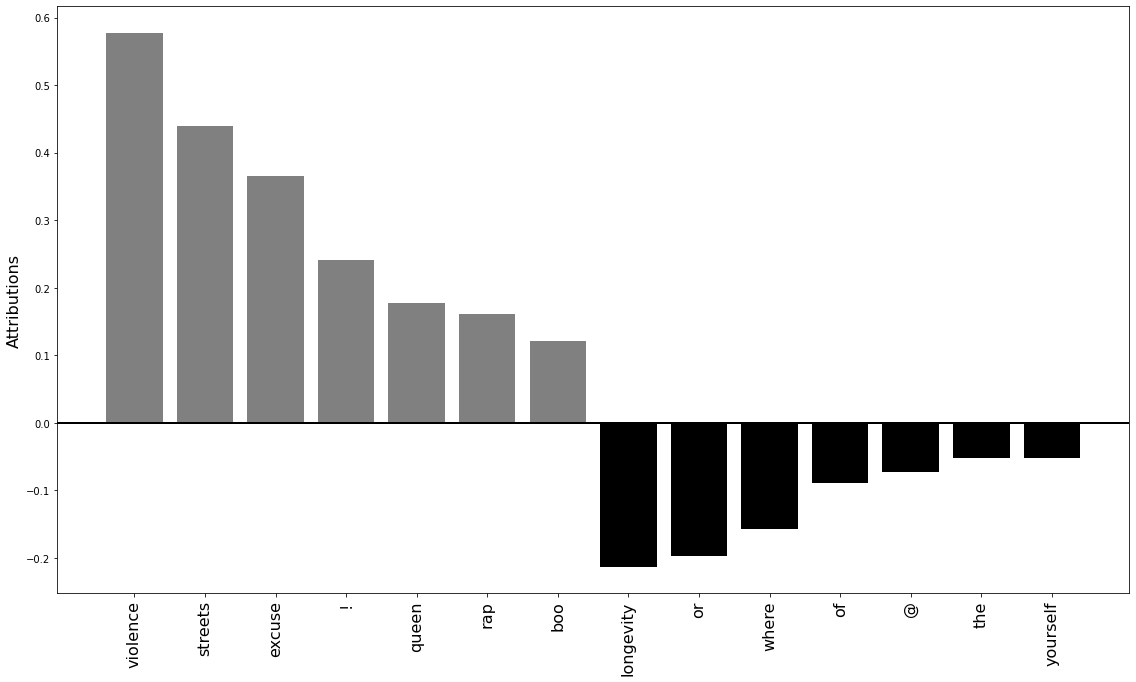

tweet: cons too the place for fed up conservatives ! ! ! label: 0


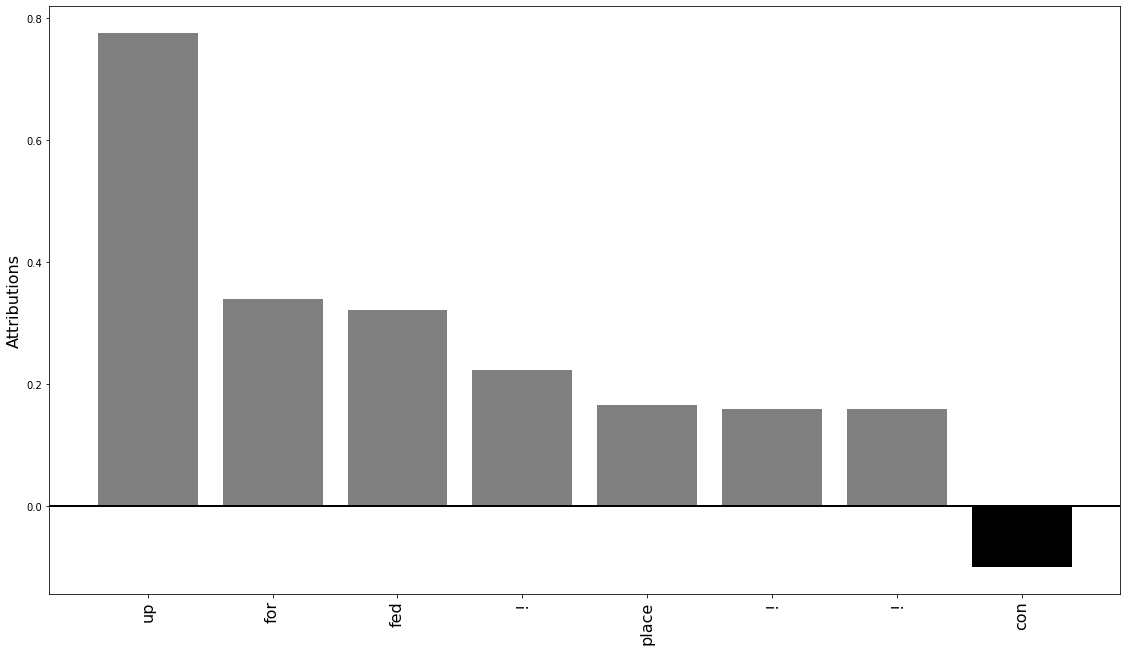

tweet: hiac damn matt hardy and randy orton put on one hell in a cell match ! ! woooo ! ! ! i hope he is okay ! ! label: 0


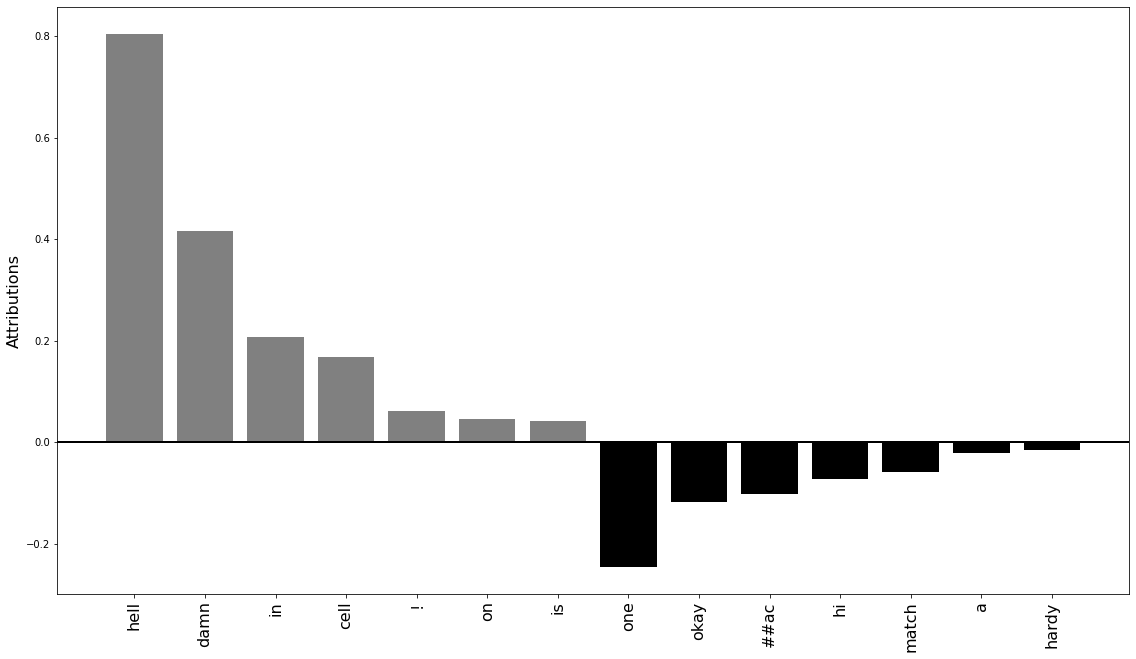

tweet: @user @user @user are you referring to how they lollygag with gun control as their kids get slaughtered in schools ? label: 0


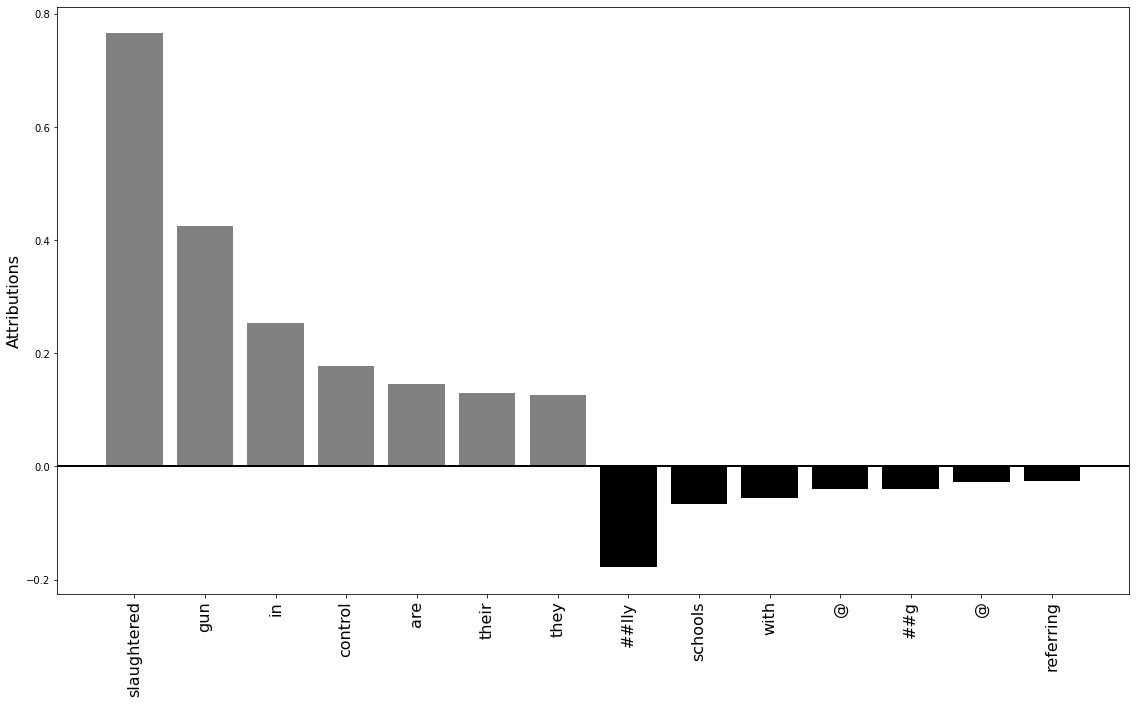

tweet: sessions tells chicago : if you want more shootings , more death , listen to aclu , antifa , black lives matter url label: 0


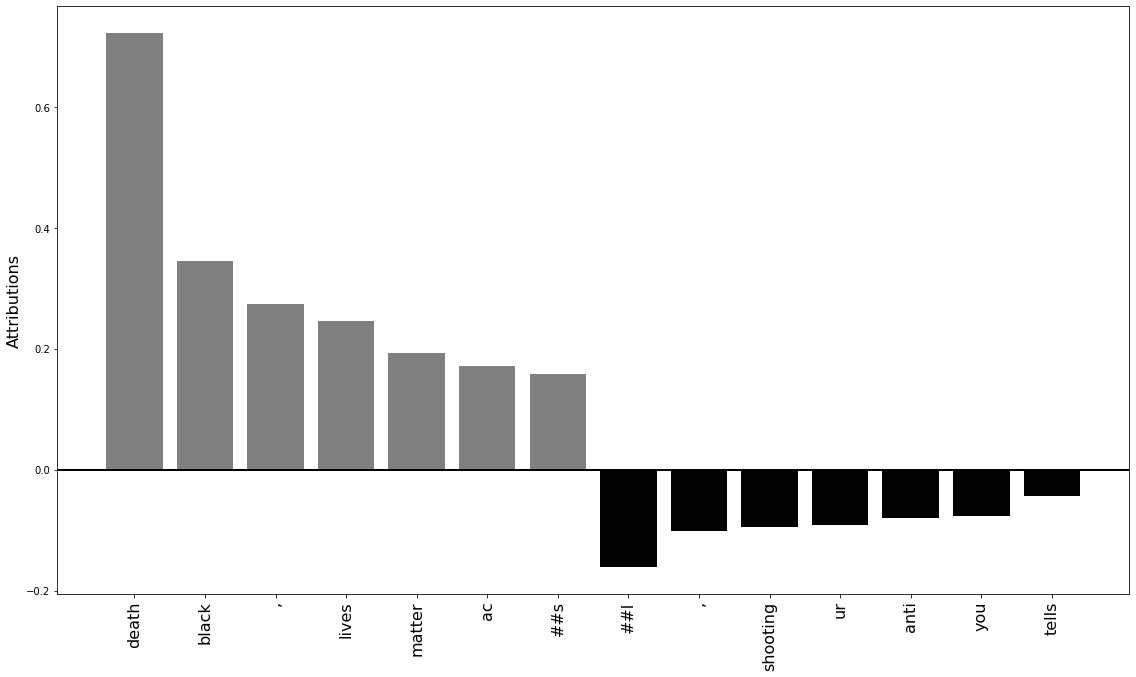

tweet: are you fucking serious ? url label: 0


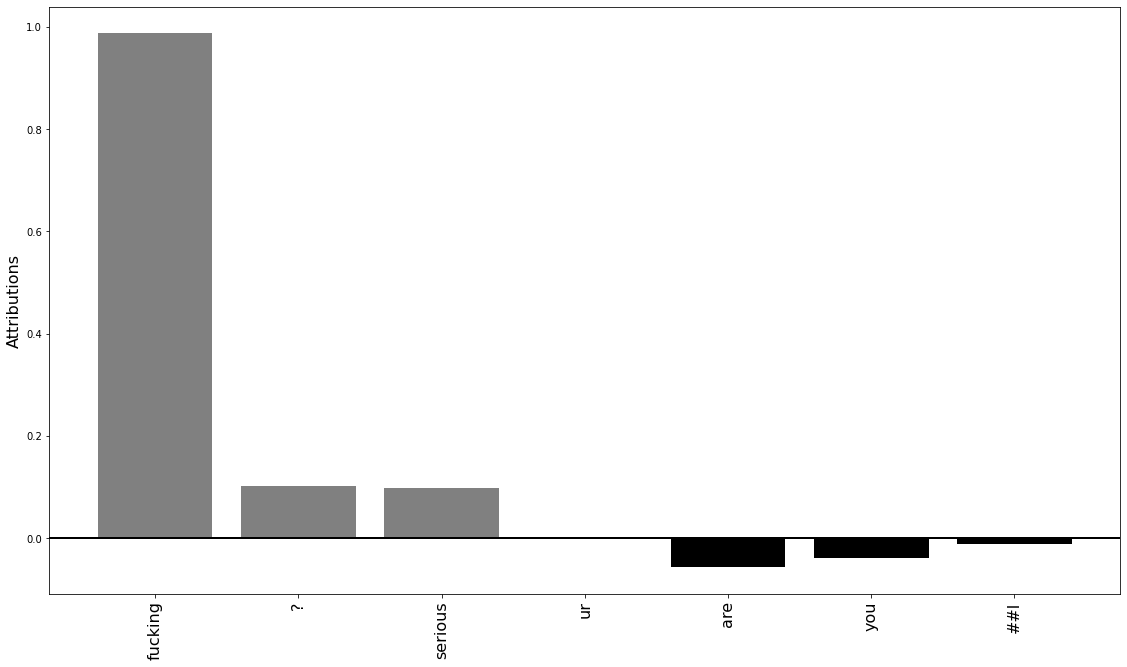

tweet: @user my only point of contention is this . he decided to keep this group which has top end talent and also decided to hire hot trash mike mccoy . wilks has not even been able to get his defense to line up correctly . he is in over his head . label: 0


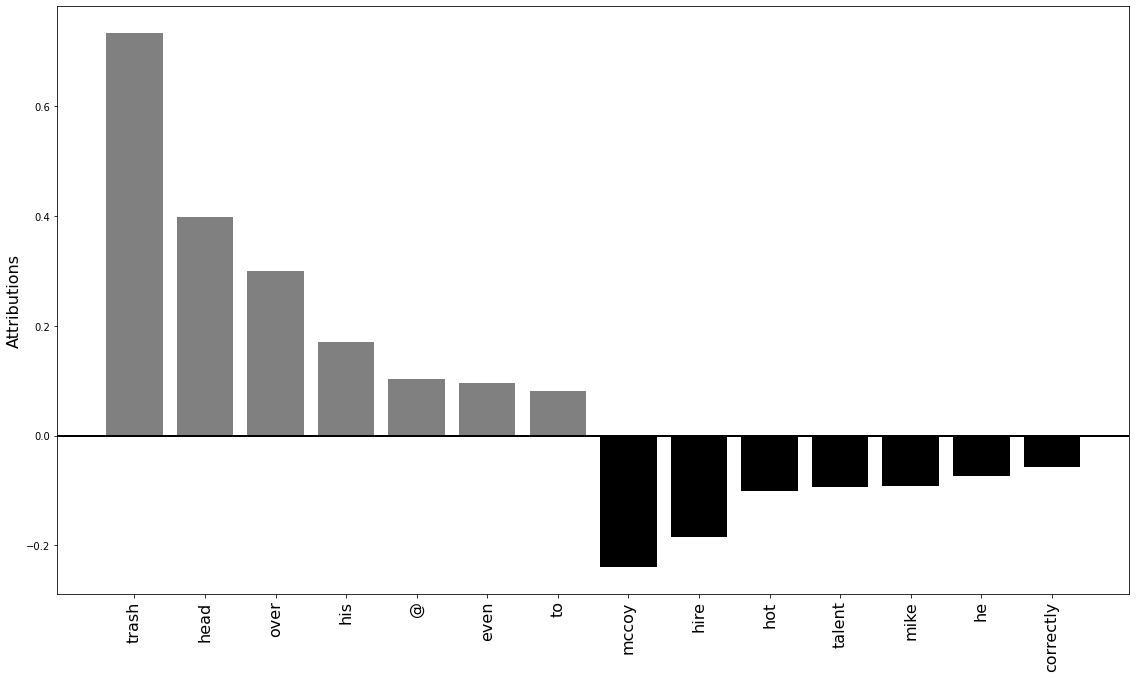

tweet: @user well she is chuck schumer ' s cousin or niece or something so she is obviously part of the dnc conspiracy against nixon . or part of the deep state . or a zionist plot . or ' big comedy ' . or whatever the hell today ' s conspiracy theory is . label: 0


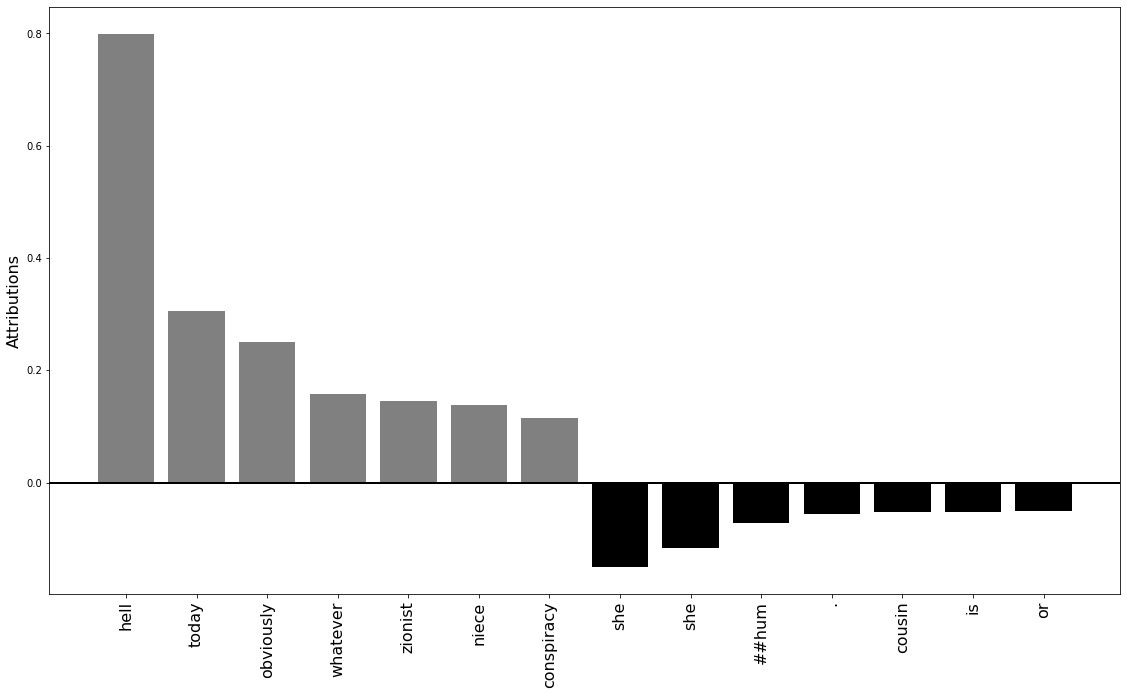

tweet: maga alert : joe biden on trump supporters : ' the dregs of society ' ( video ) url via @user label: 0


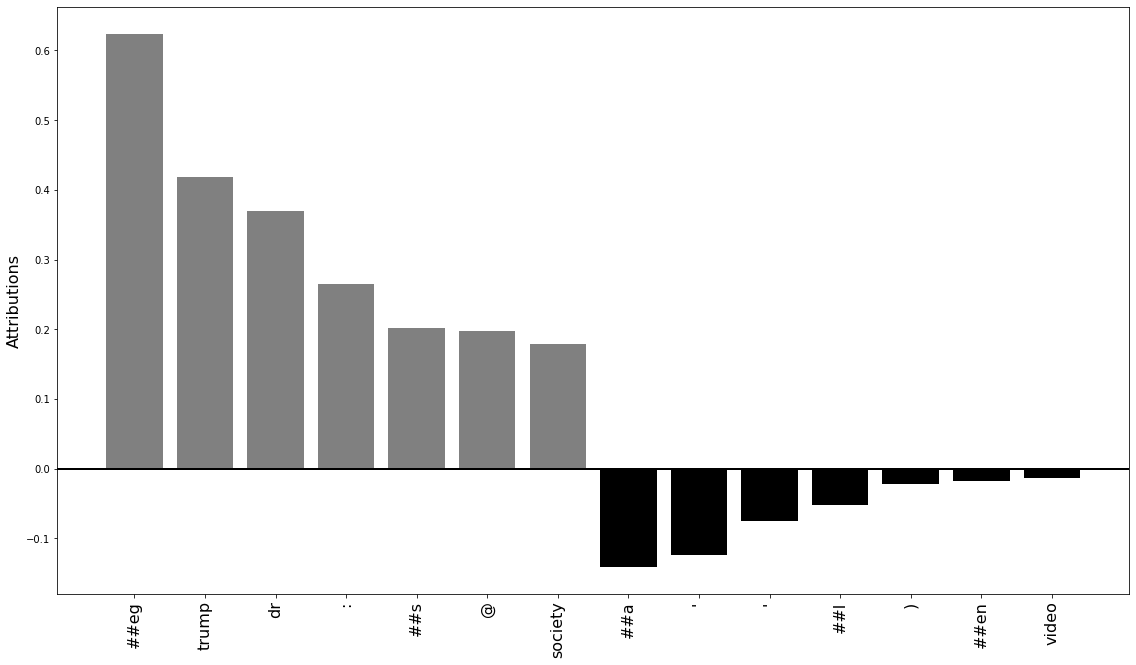

tweet: ford theatre right on cue , a gofundme acct has been set up for this person , the new liberals mode of bribery and payoffs ! @user really should investigate these gofundme as a new outlet for slush funds ! comey , mc cabe , strzok label: 0


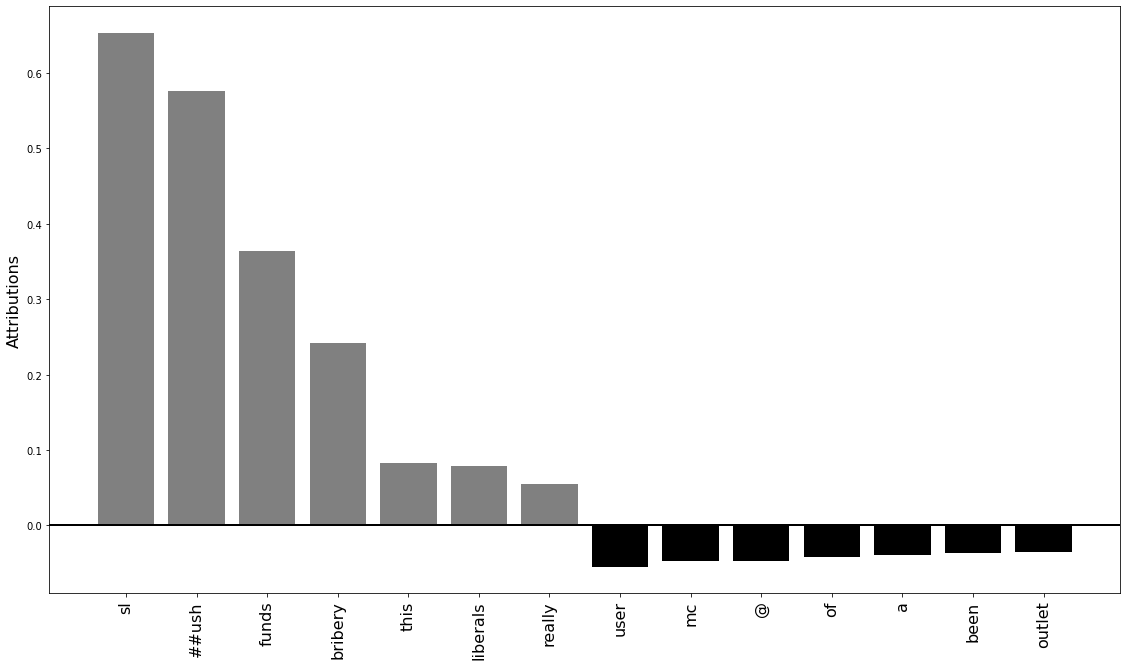

tweet: lil duval when you know u ain t going to work tomorrow happy friday smile bitch living my best life hittem with da shoulders url label: 0


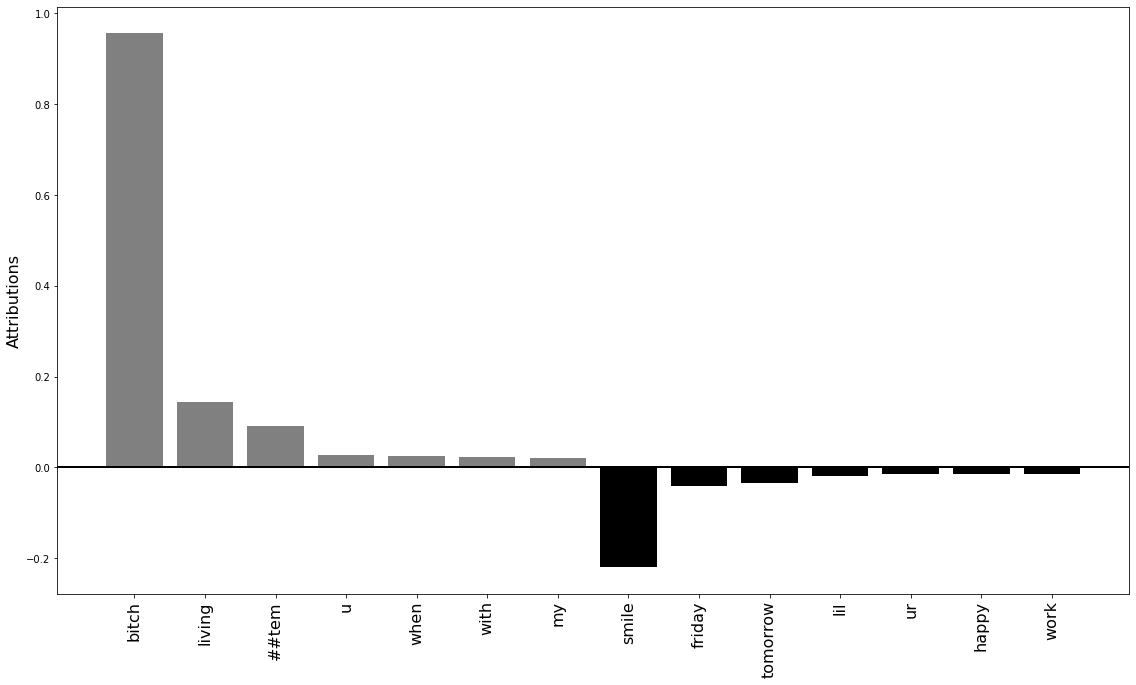

tweet: seo tips : you are the master of your own fate online , so be wise and do not expect pity . if you screw up , nobody else is to blame . label: 0


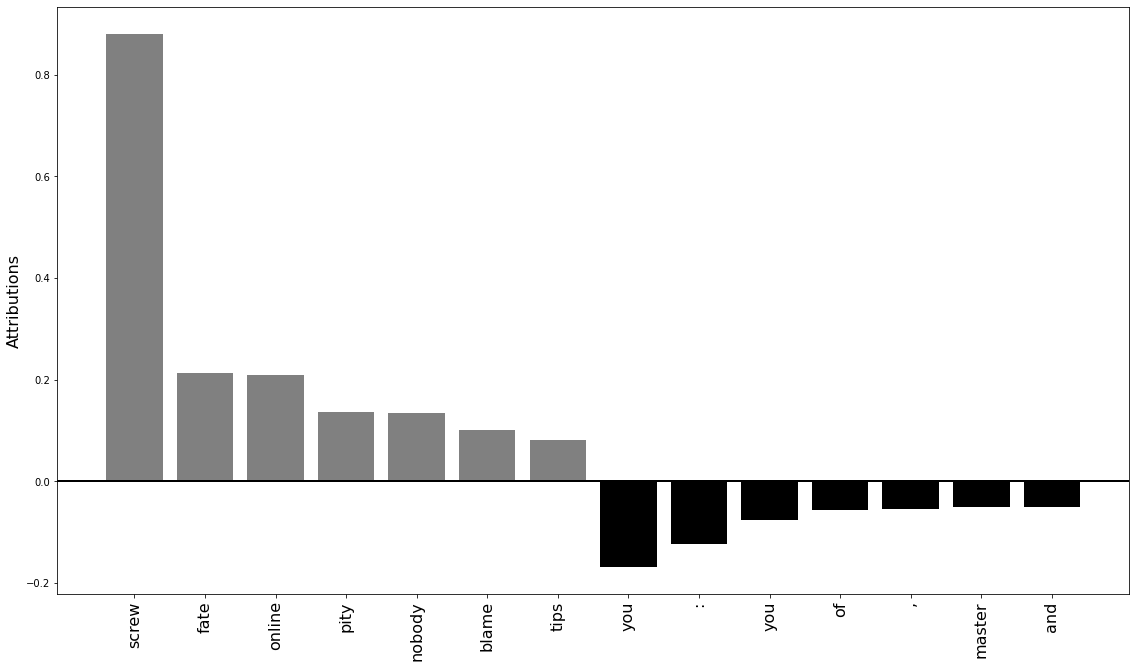

tweet: @user gun control ? i am wondering who was in control of all those bodies that got suicided because of you . you need to be controlled . <date> gitmo the pain is coming . maga q anon benghazi hope they televise your demise . label: 0


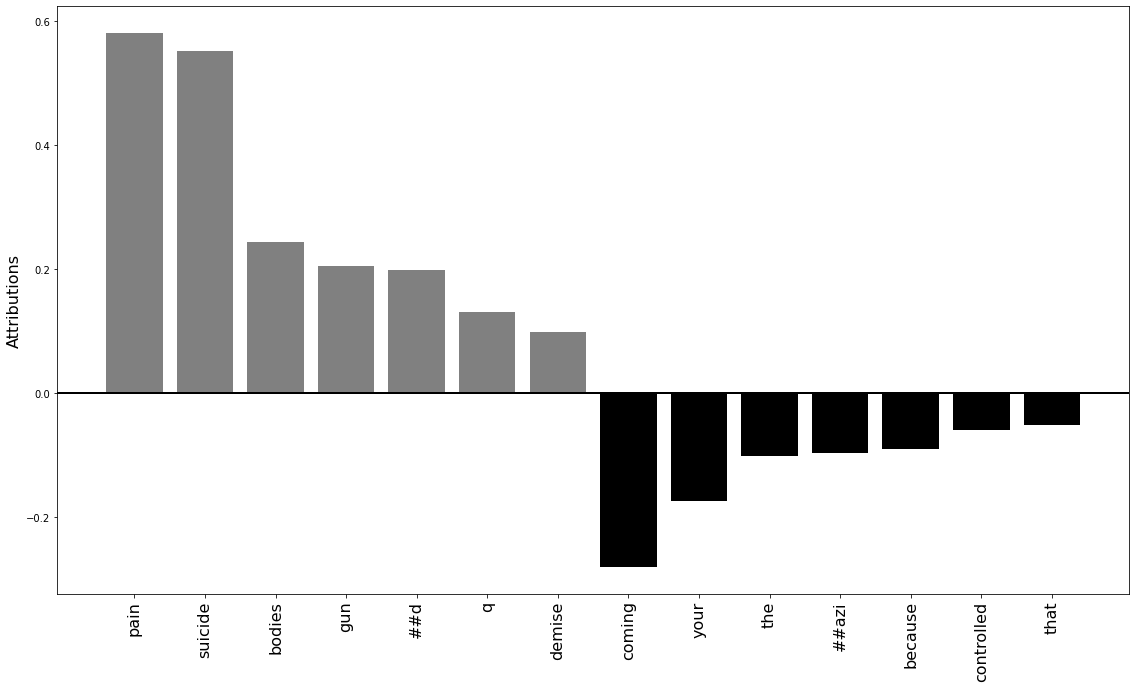

tweet: serena williams is not the first mother to be on the women ' s tour . she is embarrassingly entitled and a bully . yes , that is kim clijsters winning a major a year after having a baby . @user @user @user url label: 0


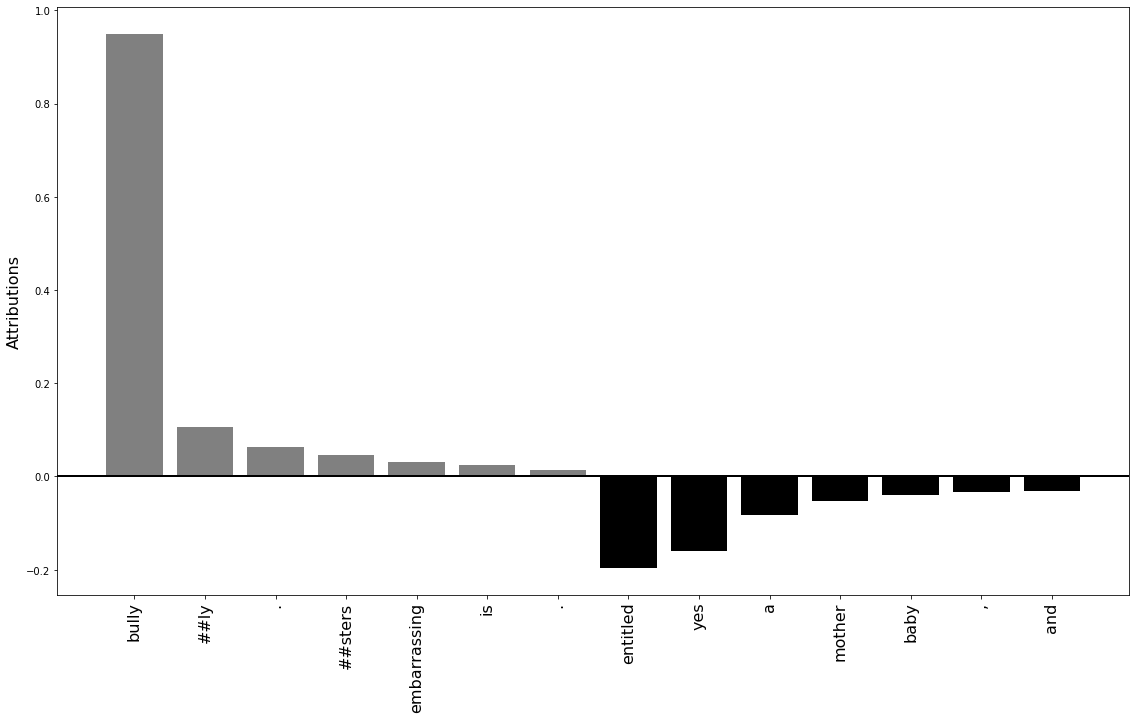

tweet: you didnt have to beat him up like that . . . all he said was you are looking so delicious . " you say as you clean up his bruised knuckles . " nobody talks to my woman that way . . . except me . " he pulls you on to his lap . " do you want me to kiss it and make it feel better ? " you tease . + url label: 0


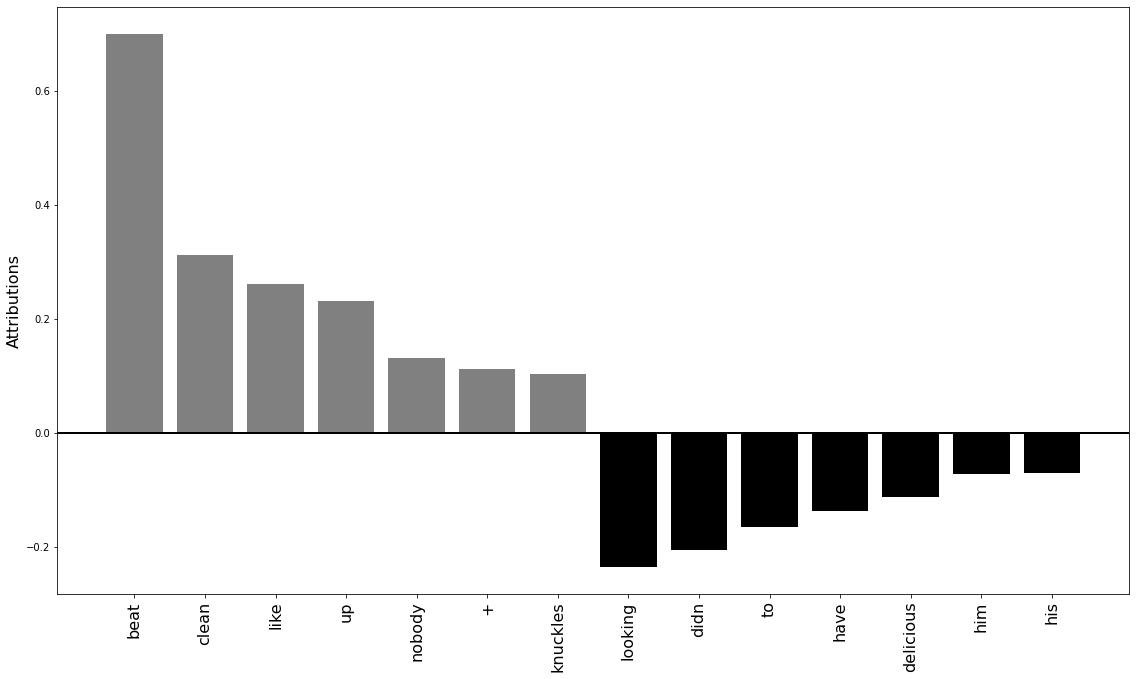

 Visualization For Score False positive predictions 


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,1 (0.06),cons too the place for fed up conservatives ! ! !,2.38,[CLS] con ##s too the place for fed up conservatives ! ! ! [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,1 (0.06),are you fucking serious ? url,1.08,[CLS] are you fucking serious ? ur ##l [SEP]


tweet: . . . what the fuck did he do this time ? label: 1


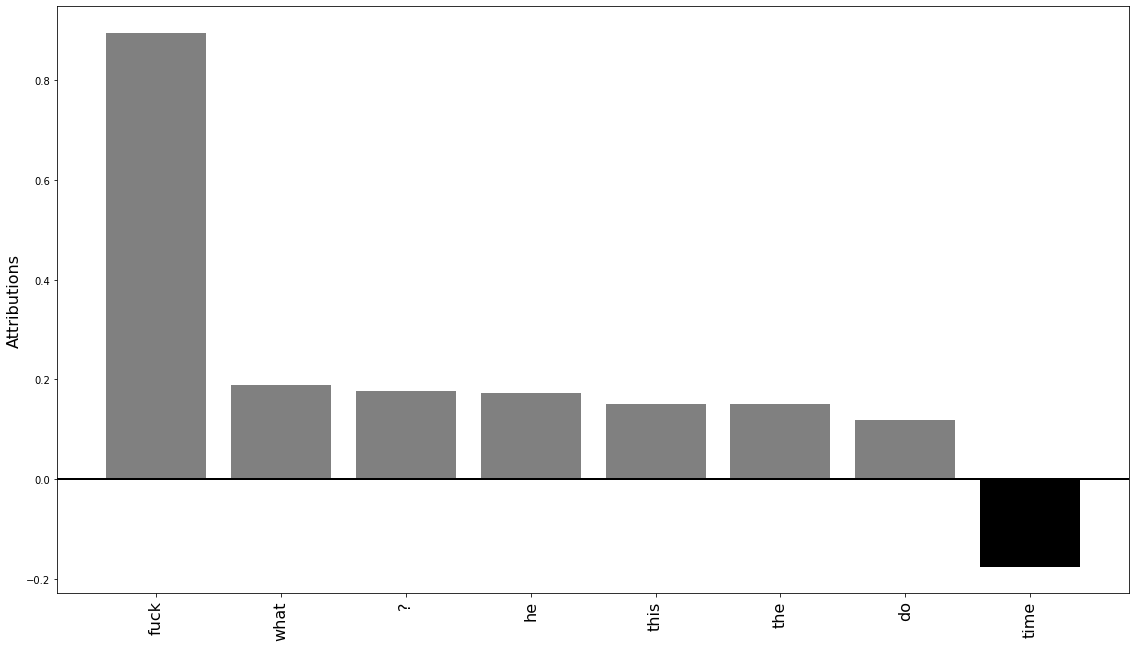

tweet: @user do you get the feeling he is kissing @user behind so he can humiliate him later ? label: 1


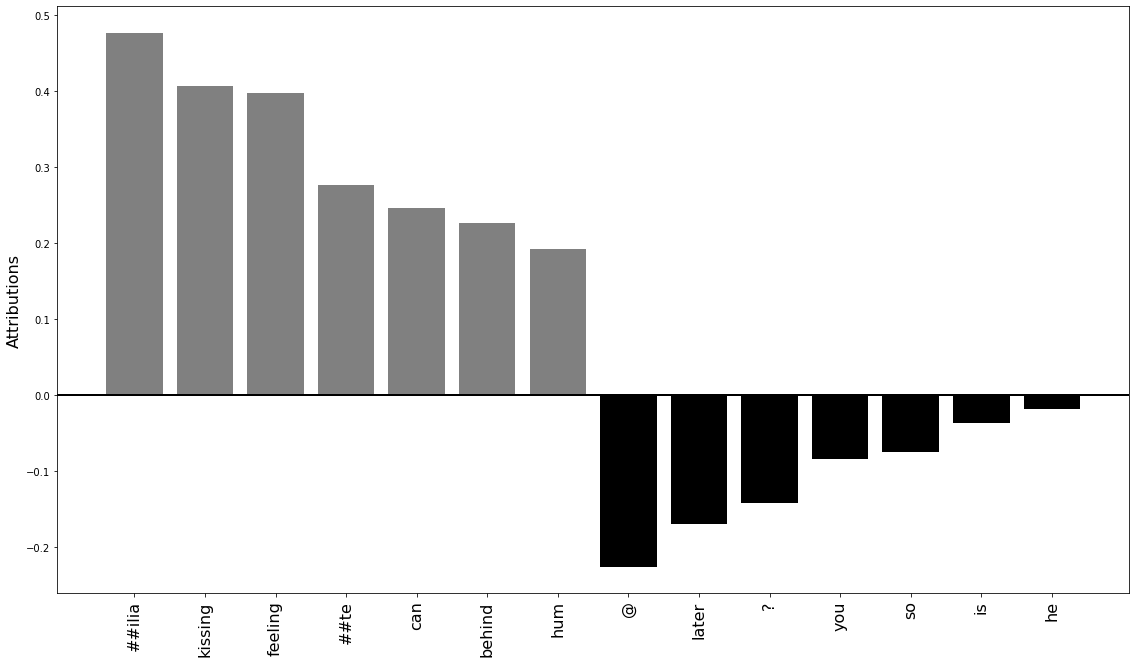

tweet: @user nigga ware da hits at label: 1


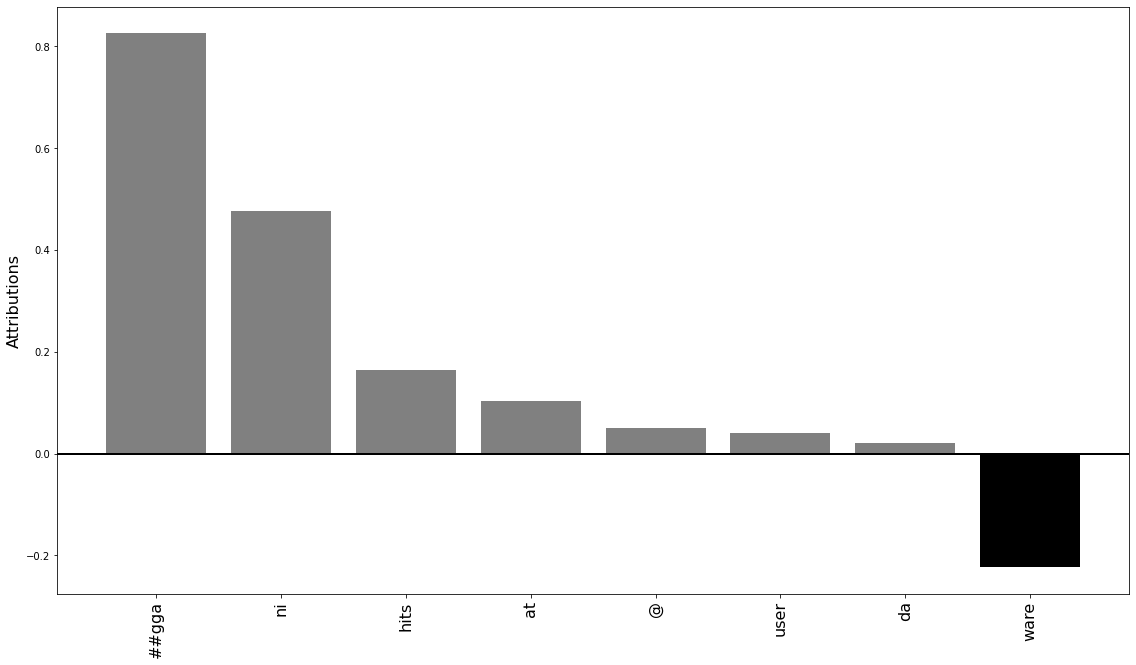

tweet: stop kavanaugh he is liar like the rest of the gop url label: 1


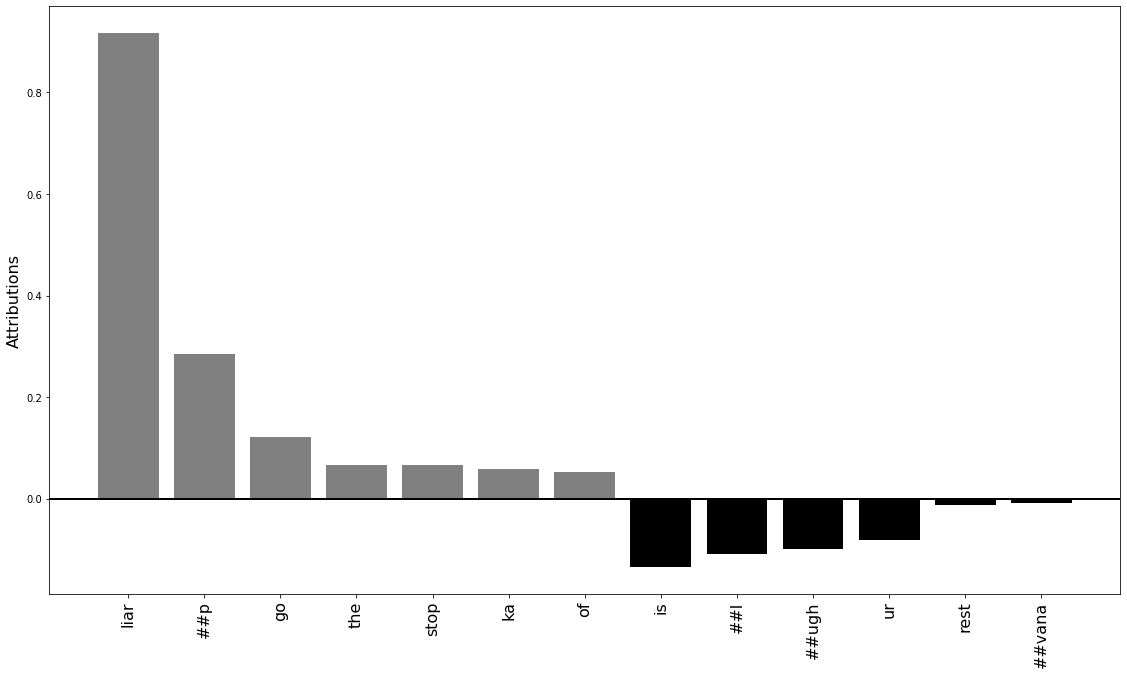

tweet: @user @user put delauro in a police lineup identifying the bag lady " - she would be picked everytime ! she has to be proof either conn voters are incompetent to vote or she is part of a vast voter fraud conspiracy ! no one votes for a woman that gross ! " label: 1


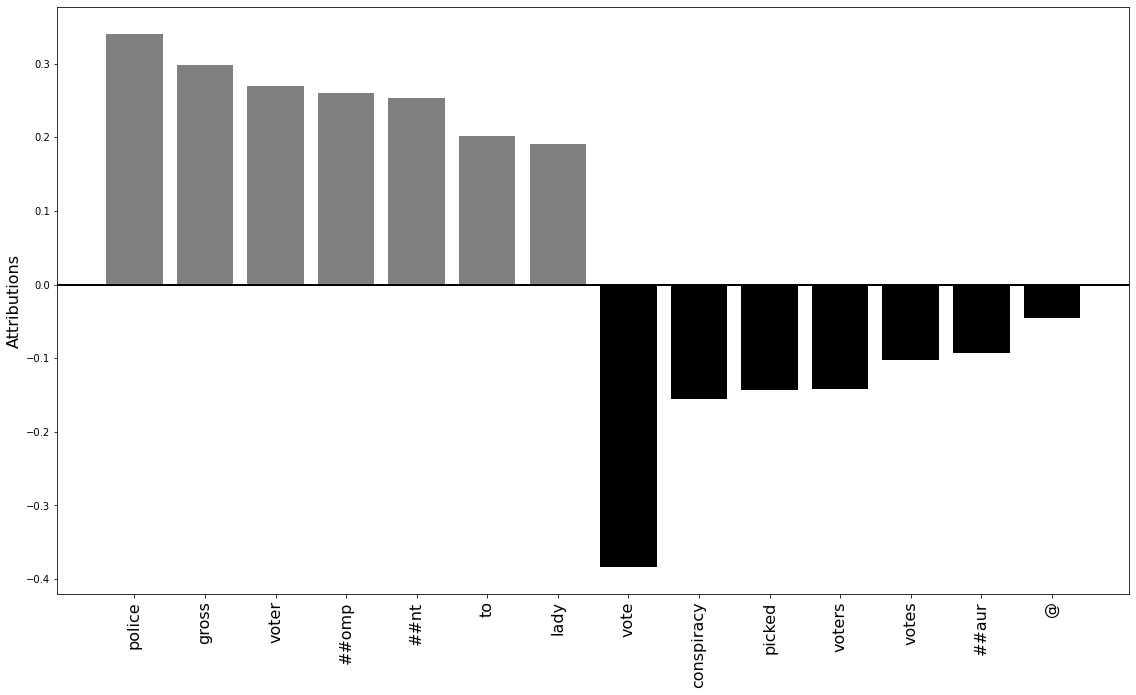

tweet: @ all family / friends , do not tell me bad shit that your bf / gf did to you just to go right back to them ! ! ! label: 1


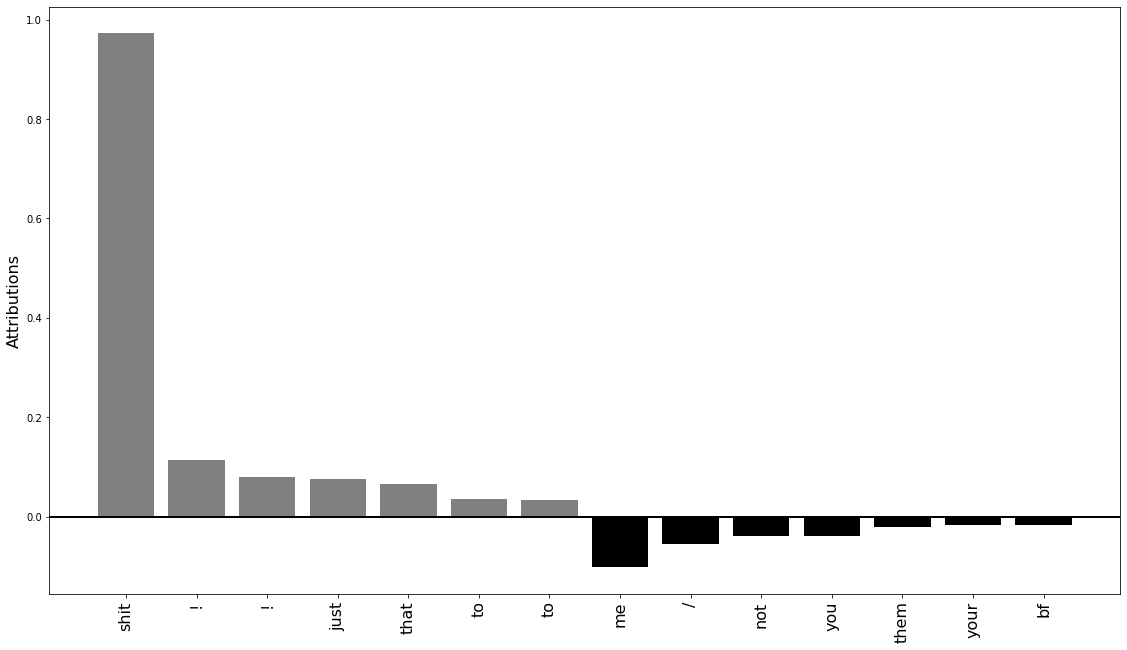

tweet: ariana asesina ? is that serious ? ! holy shit , please your fucking assholes , do not blame someone for the death of other one . she is sad enough for today , do not you see ? it is not fault of none , he had an overdose and died . end . stop wanting someone to blame , fuckers . label: 1


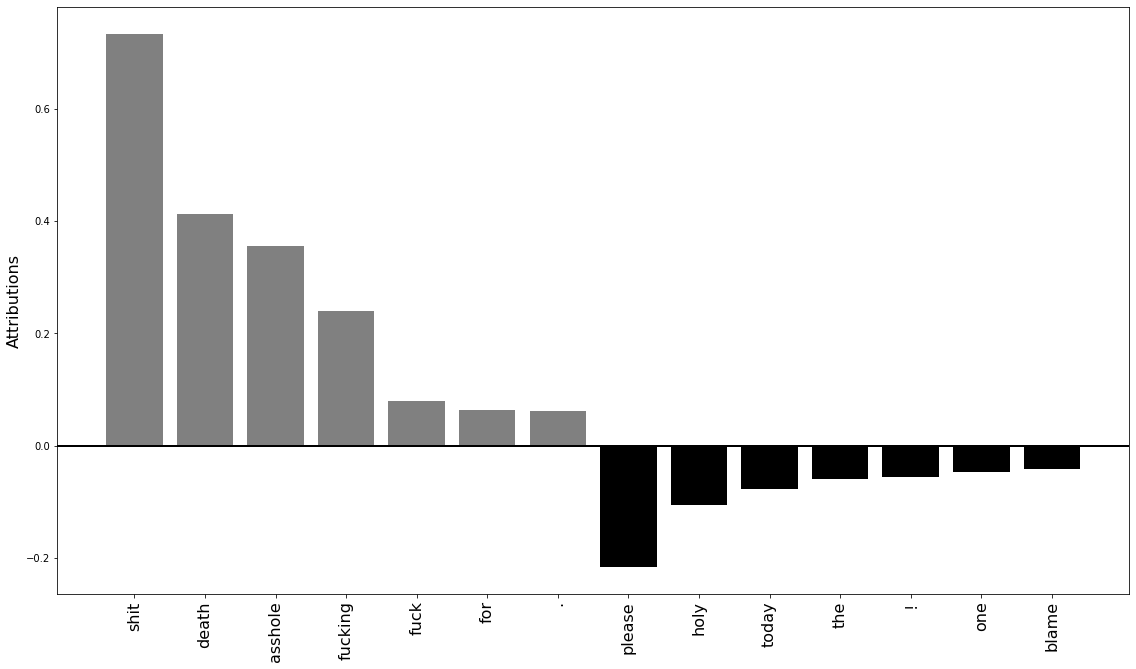

tweet: @user how is she hiding her ugly personality . she is the worst . label: 1


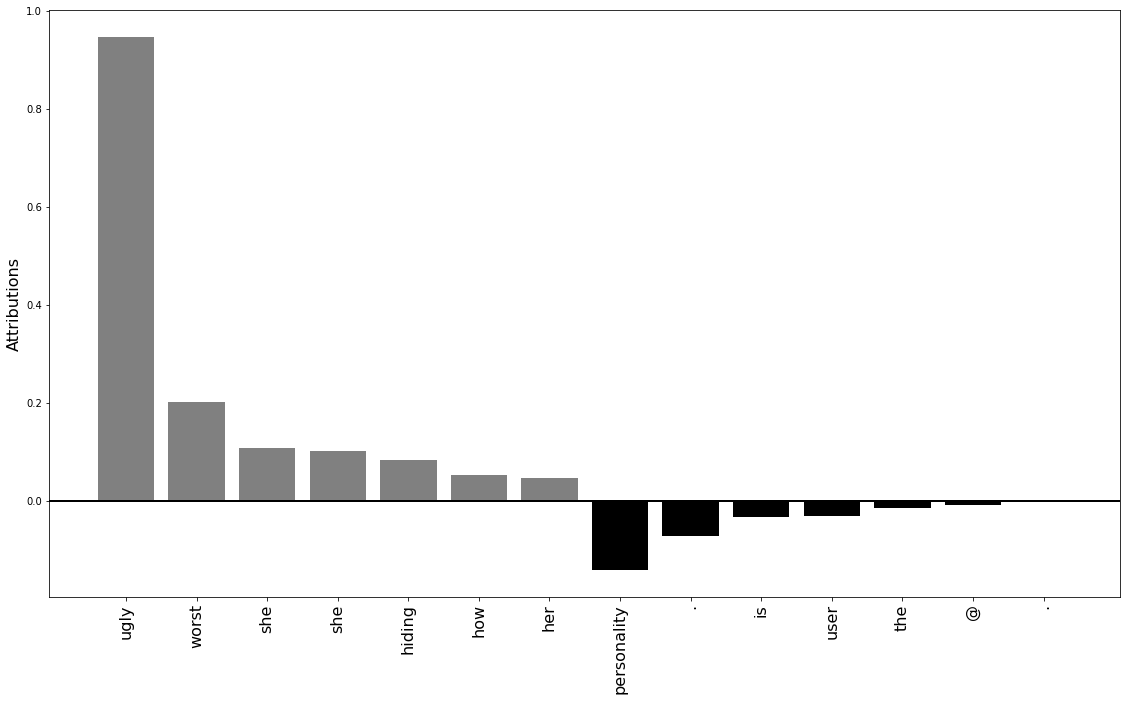

tweet: . . . . . . bitch what url label: 1


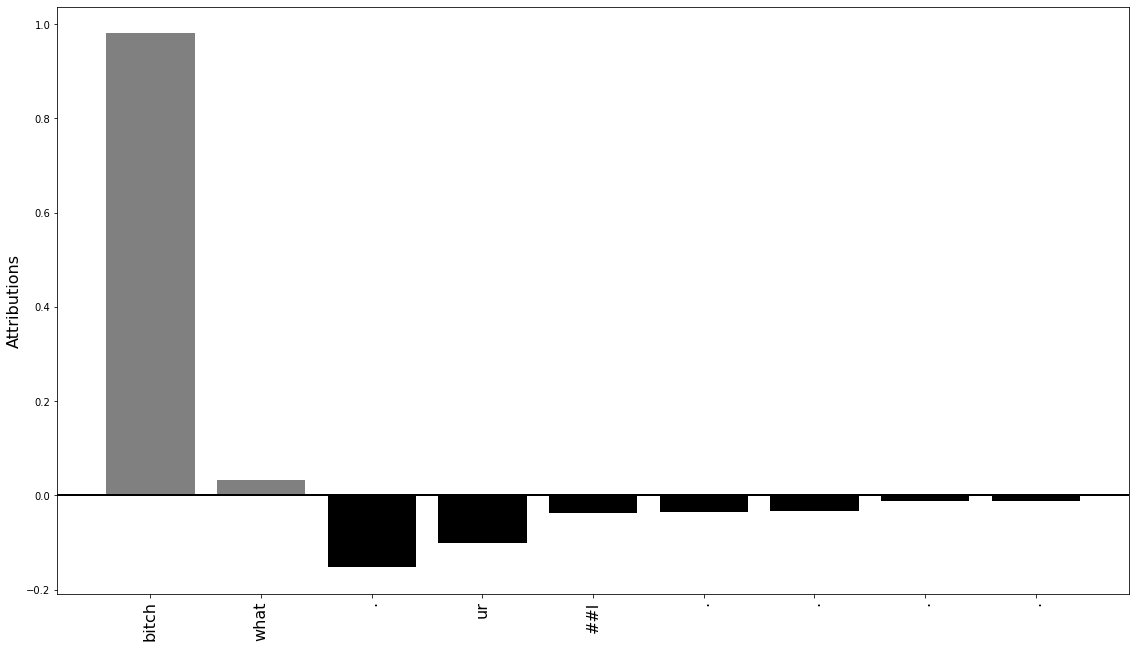

tweet: conservatives @user - you are a clown ! url label: 1


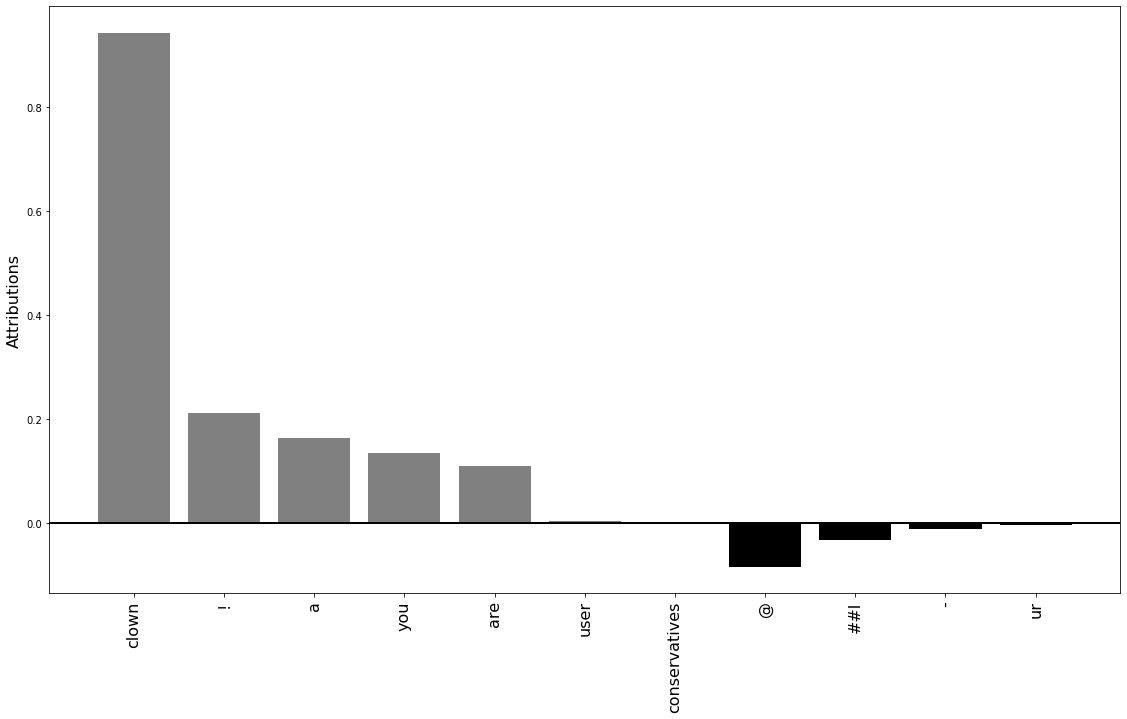

tweet: * voice in my head while i transfer money to my credit card * bullshit that i bought and have to pay for label: 1


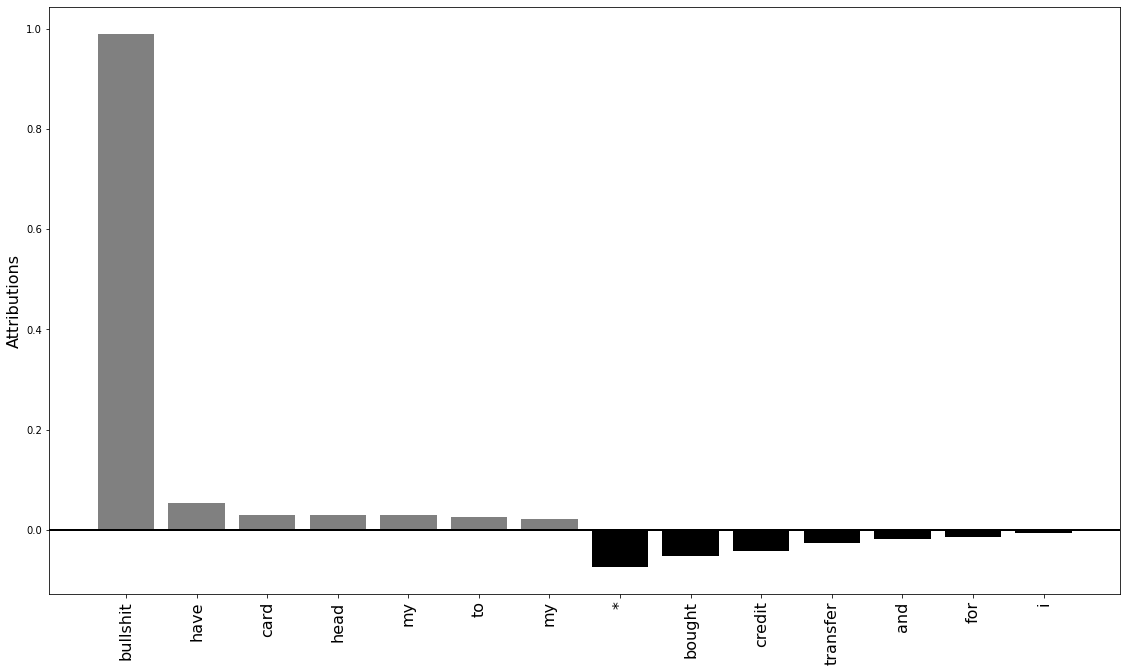

tweet: * gets all the bitches * label: 1


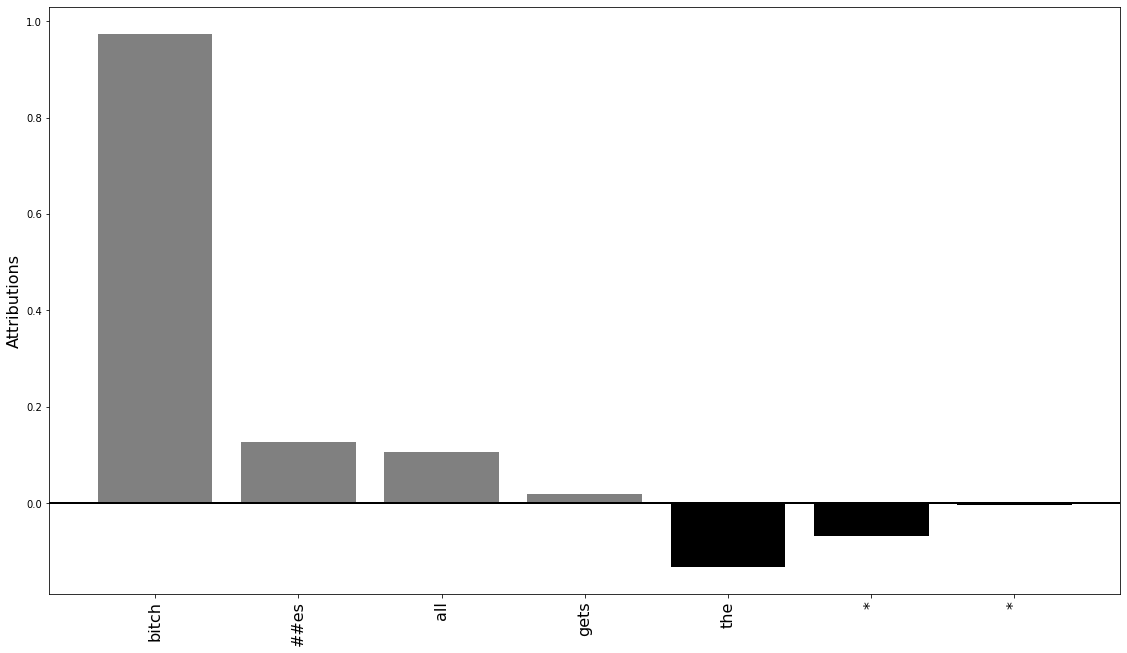

tweet: @user omg is he for real ? ! ? ! ! ? ? ? ? ? ? ) this happened in peru like <number> years ago and the inti devaluated so fucking much that they had to comoletely change the coin system because our money was worthless i - label: 1


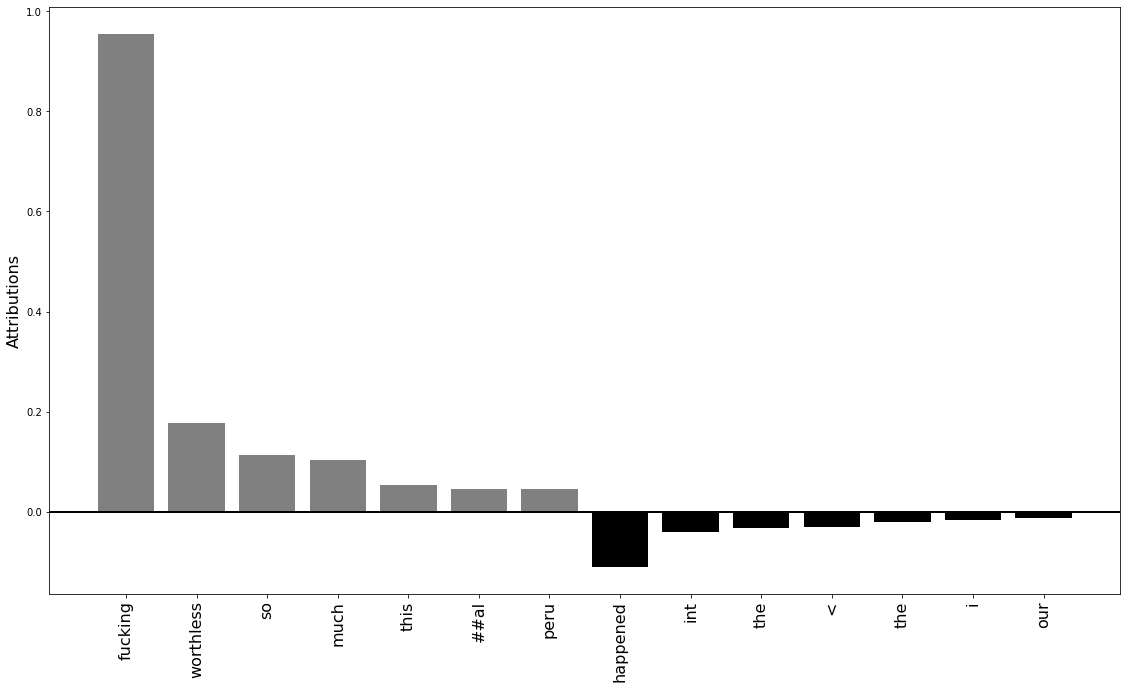

tweet: conservatism 101 it ' s not about our disagreements with conservatives . its that conservatives can not debate honestly , and they have no integrity . whatever gets them thru today , is all that matters to them . they are fundamentally dishonest people . url label: 1


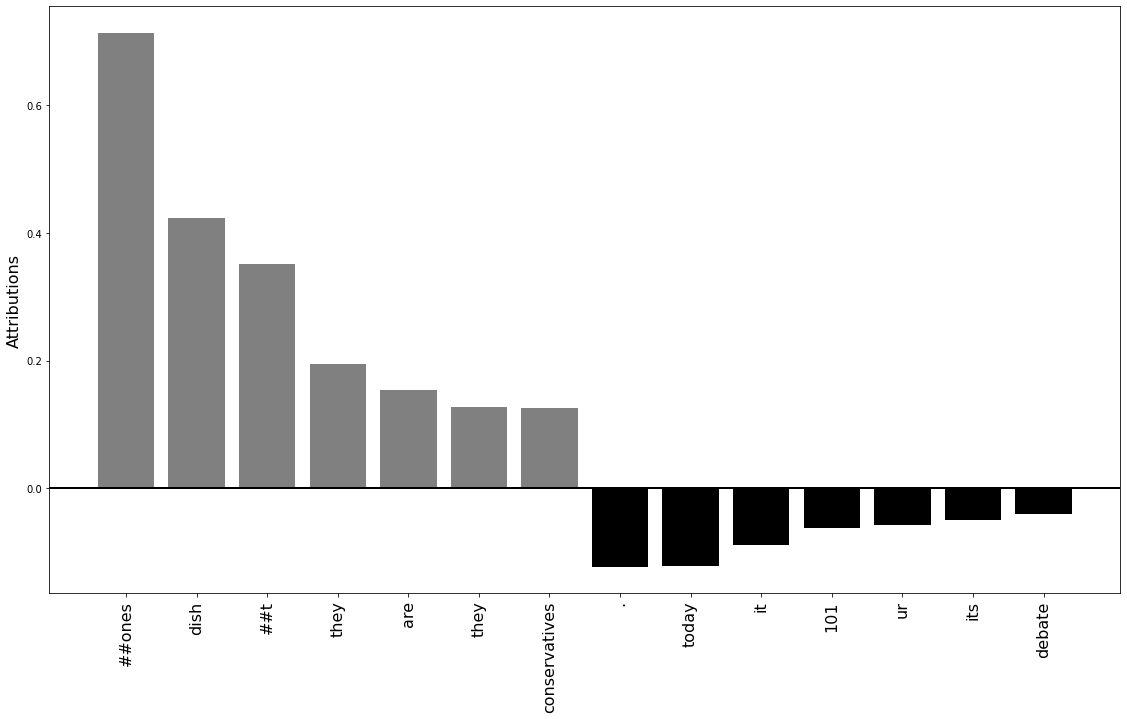

tweet: and apparently i am committed to going to a new level since i used the key . well fuck . curiosity killed the cat ( hy ) label: 1


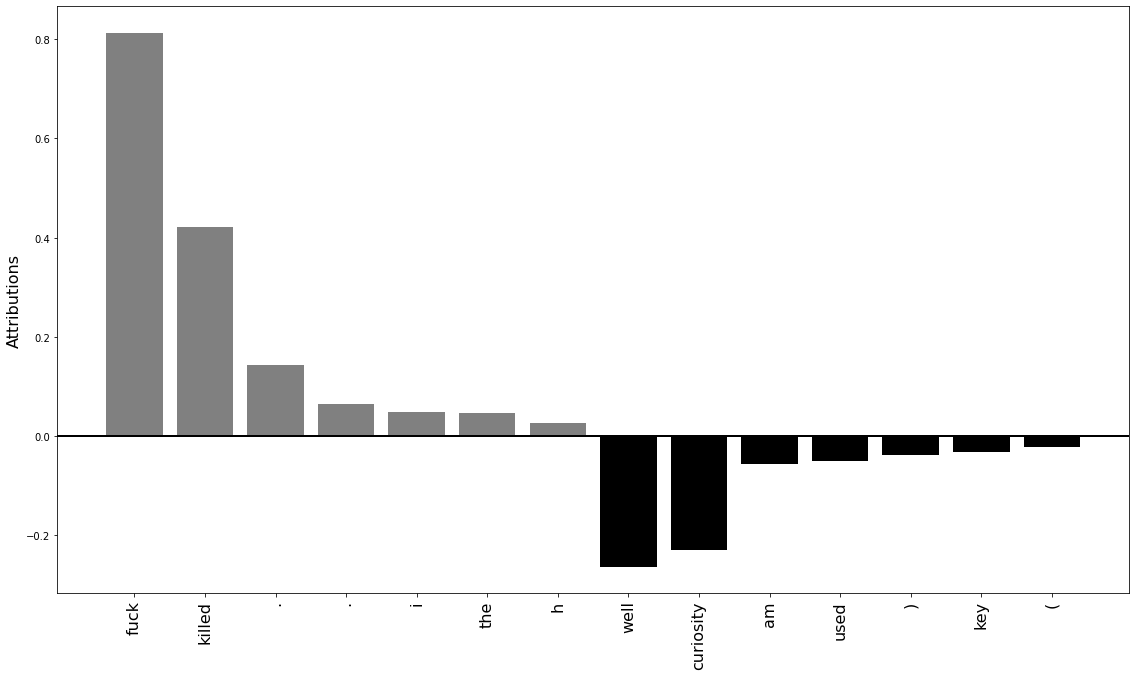

 Visualization For Score True positive predictions 


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,1 (0.06),. . . what the fuck did he do this time ?,1.89,[CLS] . . . what the fuck did he do this time ? [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,1 (0.40),@user do you get the feeling he is kissing @user behind so he can humiliate him later ?,2.23,[CLS] @ user do you get the feeling he is kissing @ user behind so he can hum ##ilia ##te him later ? [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,1 (0.34),@user nigga ware da hits at,1.46,[CLS] @ user ni ##gga ware da hits at [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,1 (0.09),stop kavanaugh he is liar like the rest of the gop url,1.19,[CLS] stop ka ##vana ##ugh he is liar like the rest of the go ##p ur ##l [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,1 (0.05),@user how is she hiding her ugly personality . she is the worst .,1.24,[CLS] @ user how is she hiding her ugly personality . she is the worst . [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,1 (0.05),. . . . . . bitch what url,0.62,[CLS] . . . . . . bitch what ur ##l [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,1 (0.06),conservatives @user - you are a clown ! url,1.45,[CLS] conservatives @ user - you are a clown ! ur ##l [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,1 (0.11),* voice in my head while i transfer money to my credit card * bullshit that i bought and have to pay for,1.02,[CLS] * voice in my head while i transfer money to my credit card * bullshit that i bought and have to pay for [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,1 (0.06),* gets all the bitches *,1.02,[CLS] * gets all the bitch ##es * [SEP]


tweet: who is q wheres the server dump nike declasfisa democrats support antifa , muslim brotherhood , ms13 , isis , pedophilia , child trafficking , taxpayer funded abortion s , election fraud , sedition and treason ! ! ! lock them all up wwg 1 wga q anon @user url label: 1


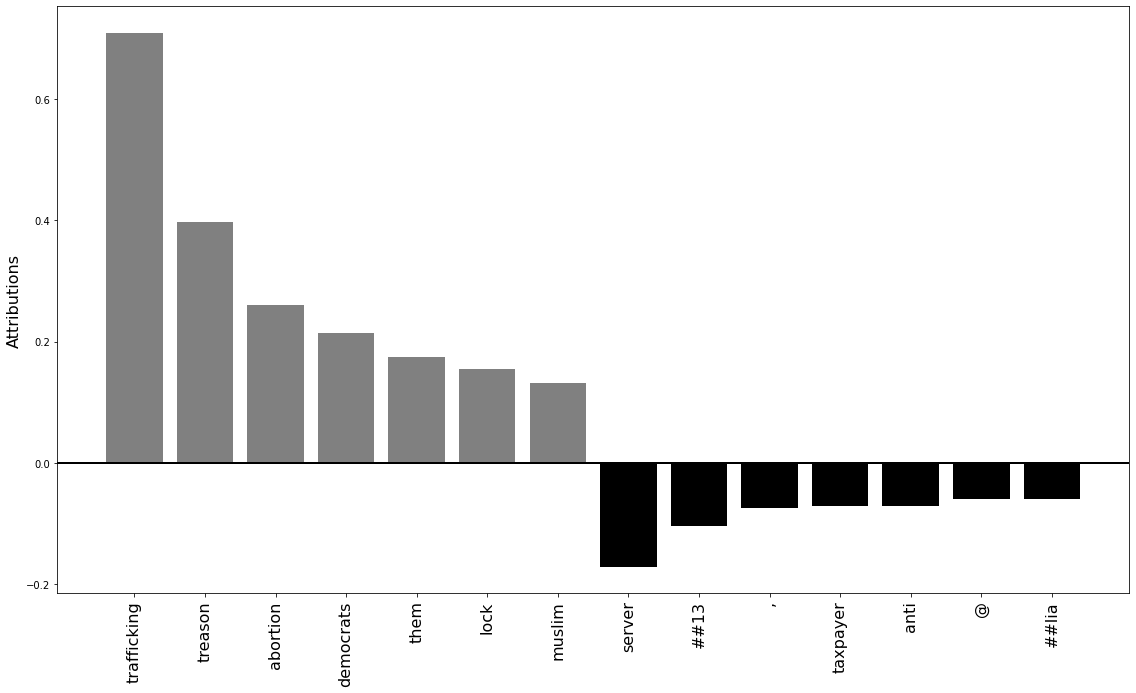

tweet: no pasaran : unity demo to oppose the far - right in london antifa oct 13 enough is enough ! url label: 1


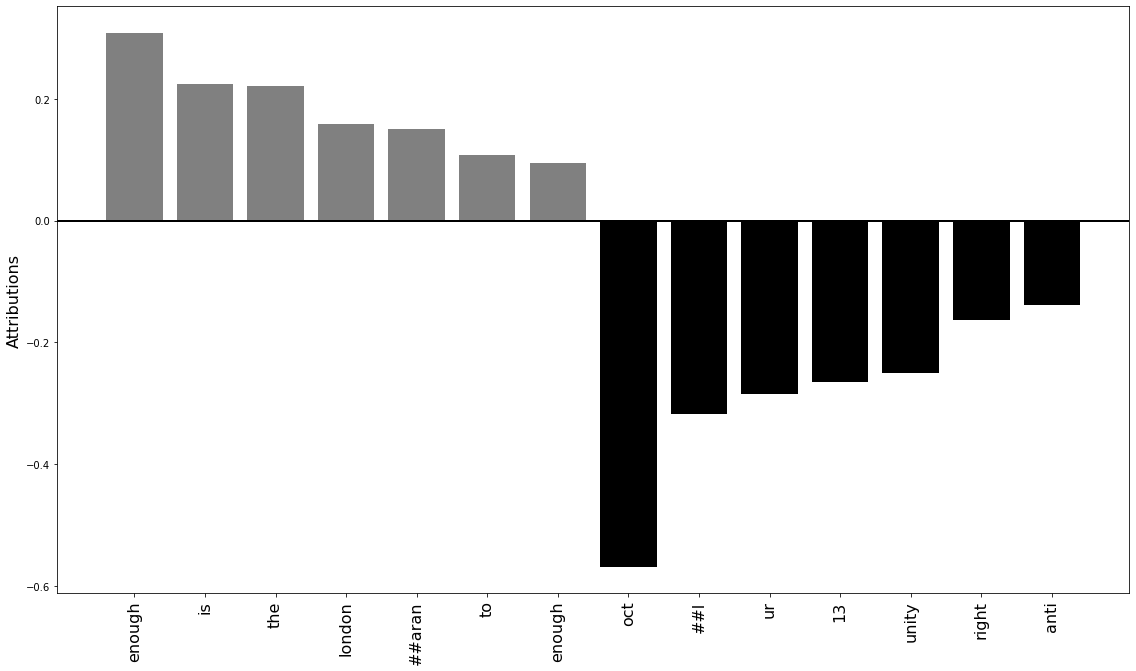

tweet: christine blasey ford is your kavanaugh accuser . . . liberals try this every time . . . confirm judge kavanaugh url label: 1


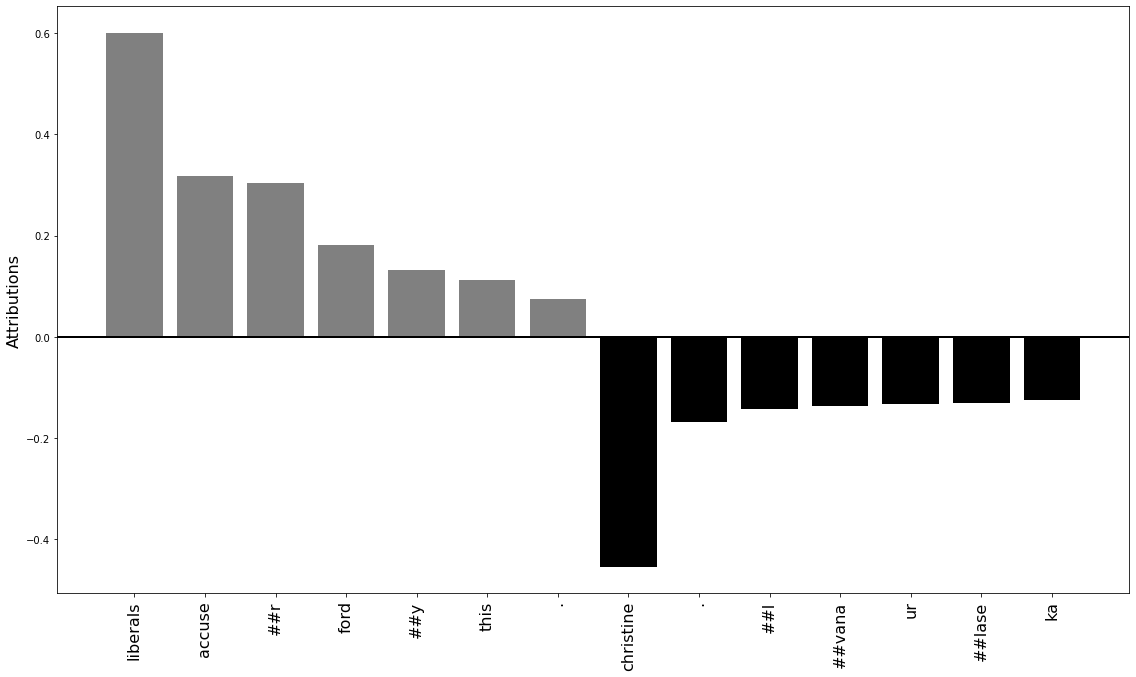

tweet: @user @user @user @user @user @user @user @user @user i m shocked to learn human traffickers had guns . some probably illegal too . ca needs more gun control . but don t worry about the actual crime . the pic of black guns is worse . label: 1


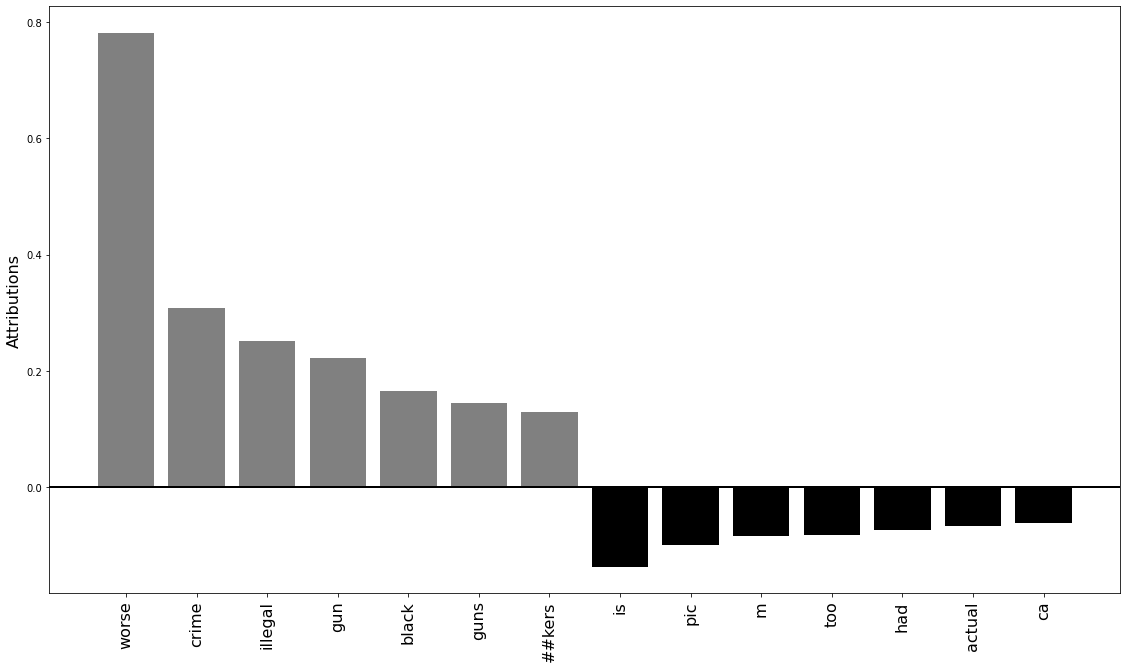

tweet: kids beating paraplegic trump boy ! left teach their children hate violence ! schools teachers democrats liberals walk away moms mother nea teach them young christian catholic jews evangelicals family black women black twitter blacks news media disabled maga url label: 1


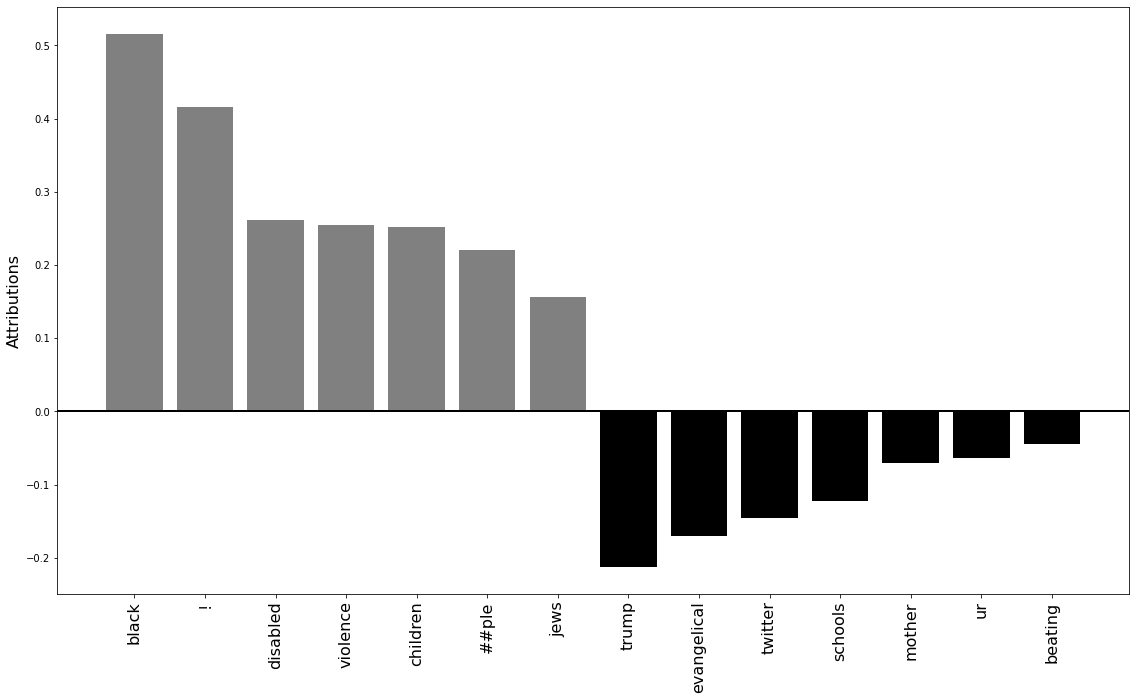

tweet: antifa : take note of how to protest with civility . this is why socialism ( aka communism ) will never win . it is inherently evil and unsustainable . url label: 1


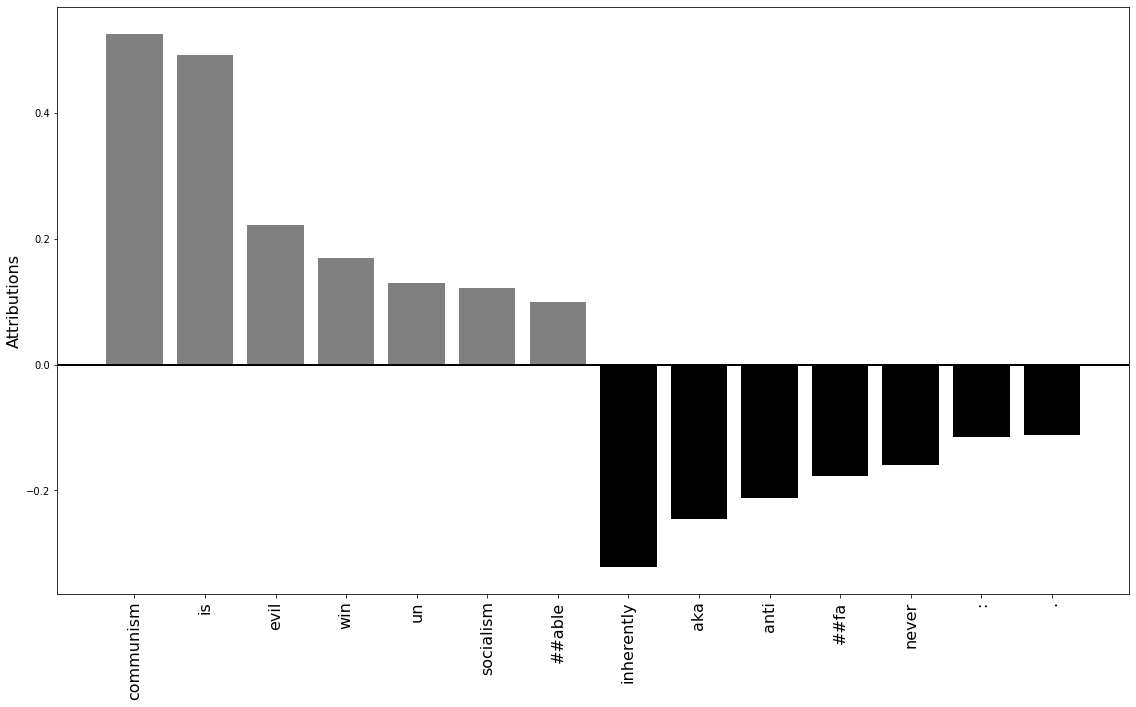

tweet: antifa are bedfellows with the democratic socialists of america ( dsa ) who james o keefe has exposed as being inserted throughout government , attempting to bring down america trump maga deep state url label: 1


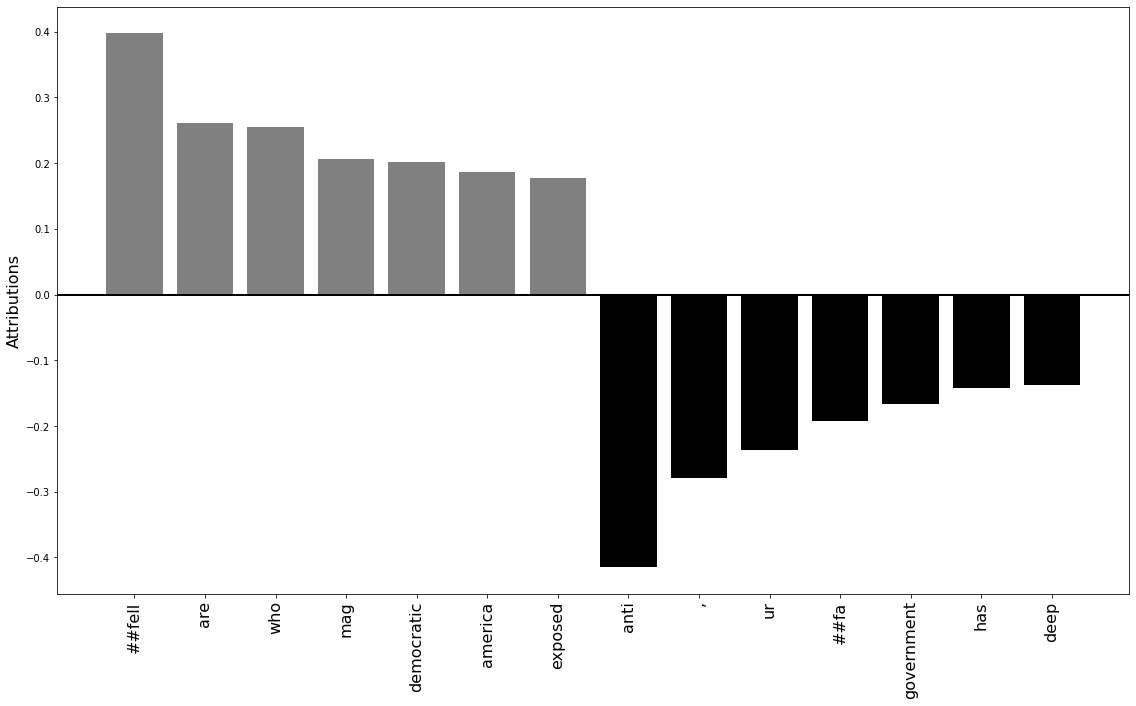

tweet: @user antifa has ts level influence . it ' s scary . label: 1


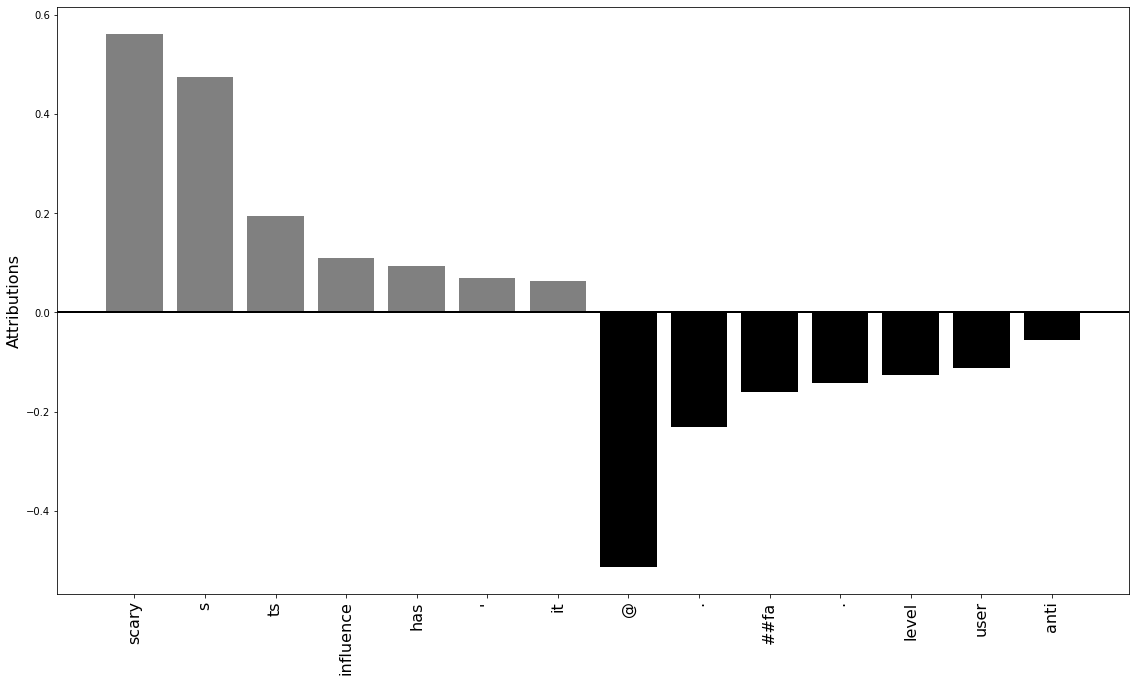

tweet: serena williams is so full of herself . . . she is just as painful to watch as to listen to . . . label: 1


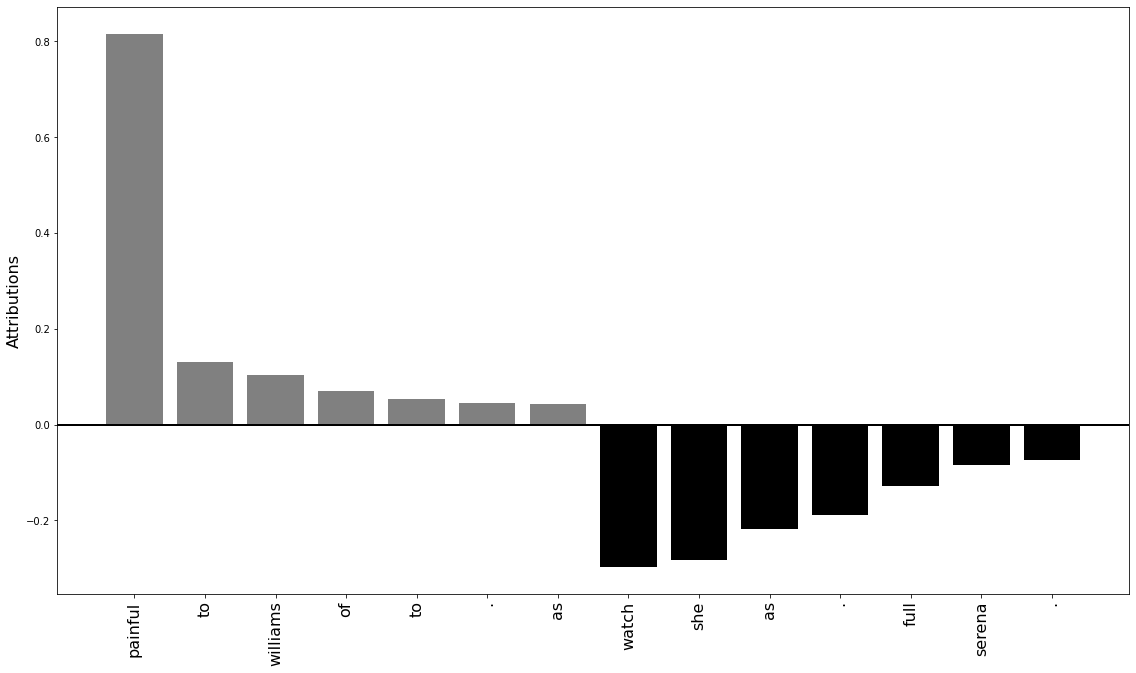

tweet: . jeff sessions : listen to the aclu , antifa , black lives matter if you want more chicago shootings . url label: 1


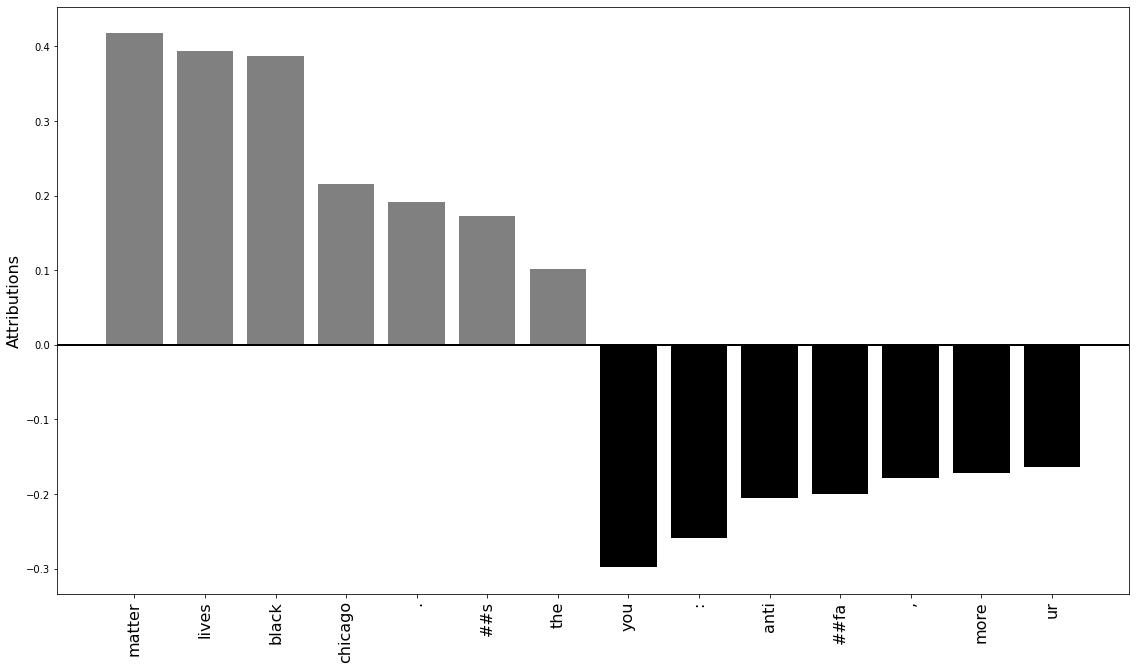

tweet: maga qanon great awakening inners wwg 1 wga now comes the pain walk away goodbye democrats ellison accuser says she ' s been sidelined by her own party url label: 1


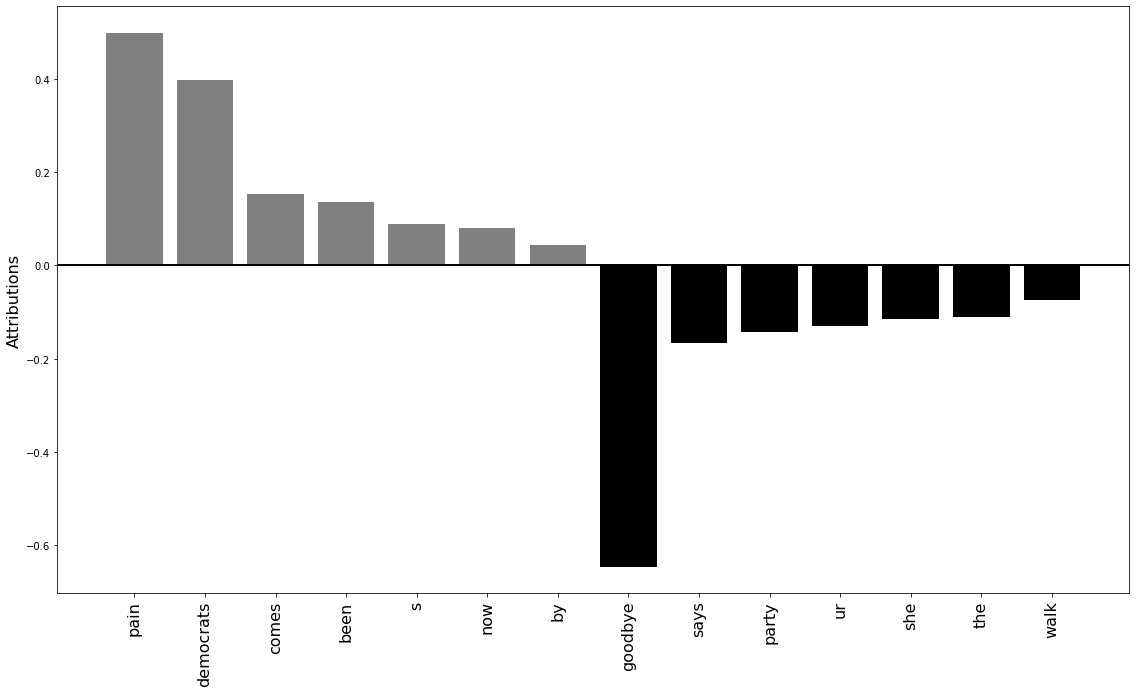

tweet: @user walk away from all democrats michelle was there <number> years and we sure do not need any more bad advice from her now . we have a new sheriff in town , who ' s maga . get out and vote - all colors , all genders ( aka ) all americans ! ! ! url label: 1


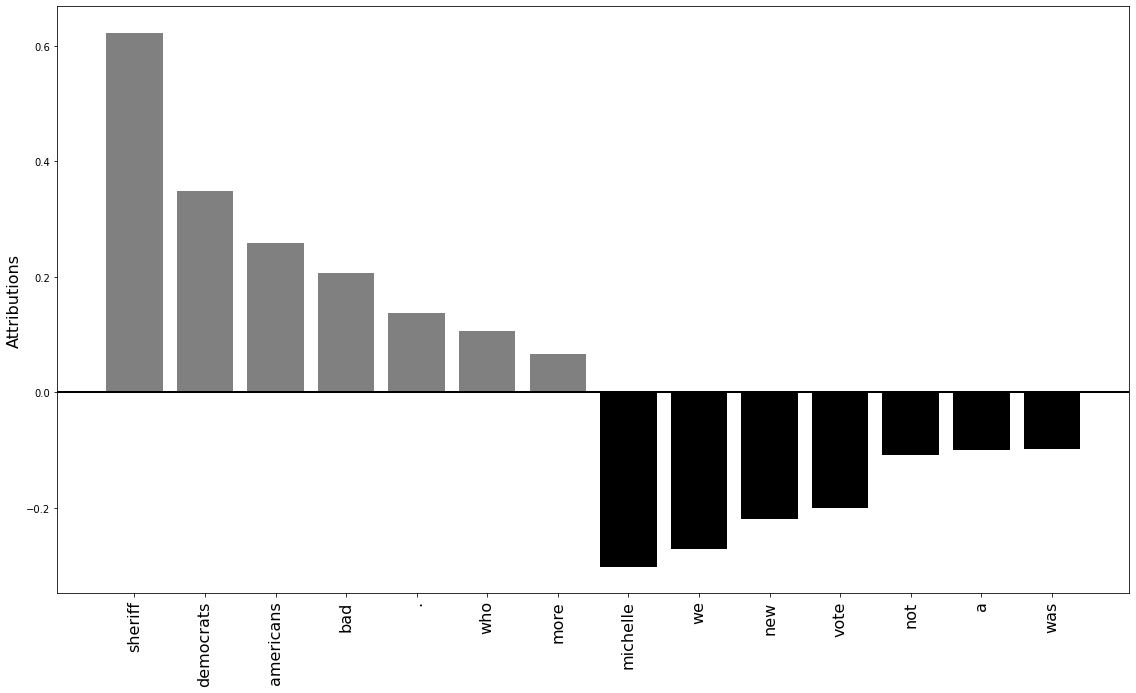

tweet: blasey ford it s so comical that liberals always want it both ways first women need to be treated as equals but when it comes to ford testifying they say it s unfair to have more men asking her questions . which is it dems are women equal or should we receive special treatment ? label: 1


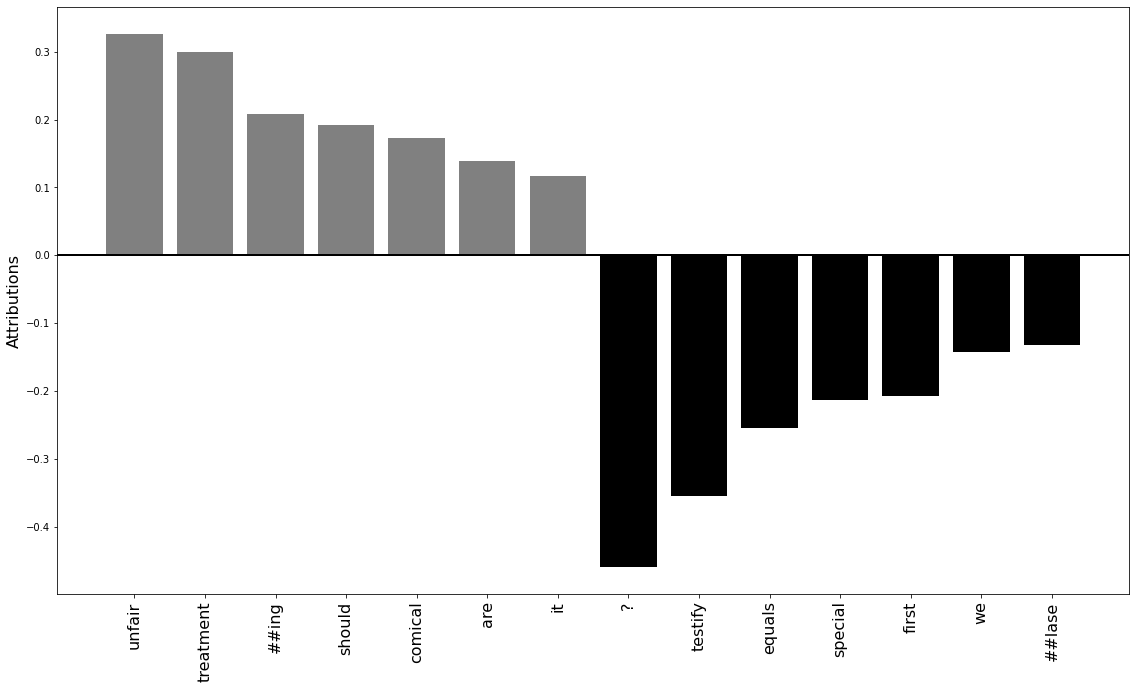

tweet: ted always has a feel for the most appropriate public behavior . but , often , he is unable to control himself . gop dysfunction url label: 1


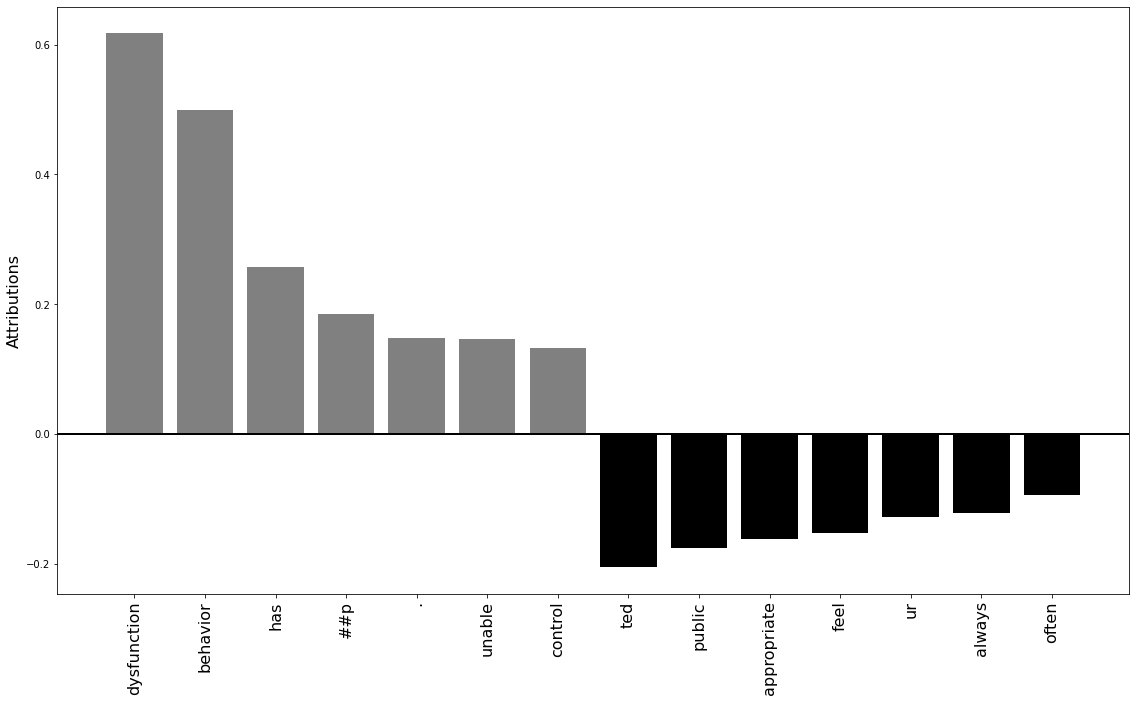

tweet: emmy awards 2018 - ratings tank as expected . who can possibly stand to watch so many liberals in one place at one time . label: 1


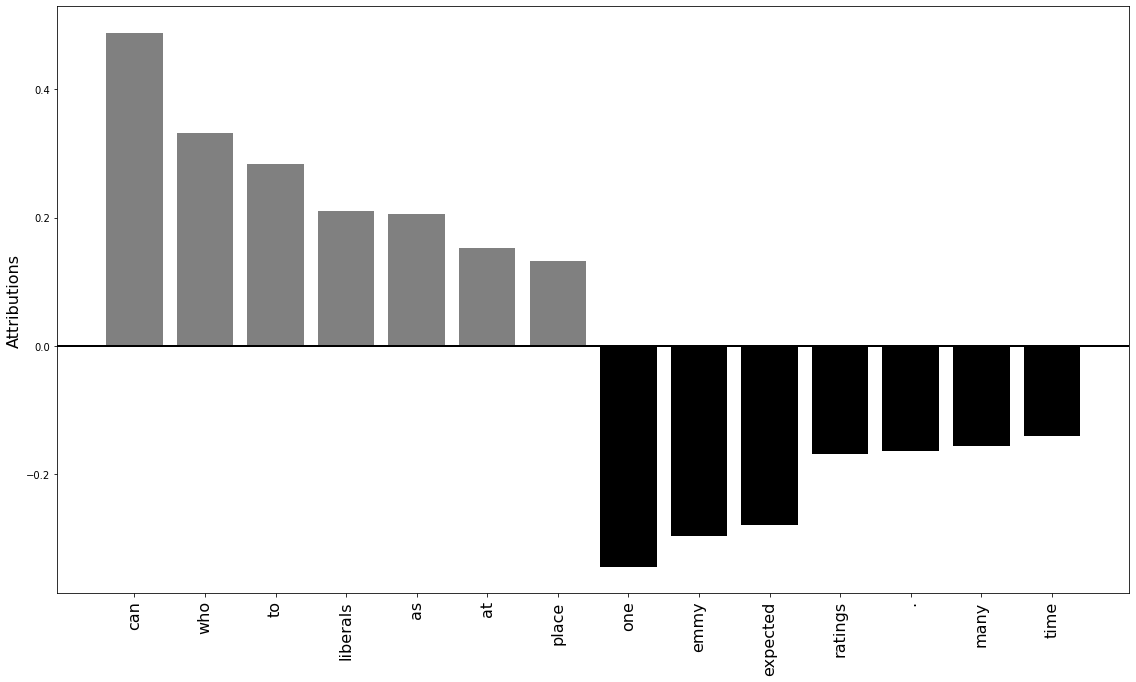

 Visualization For Score False negative predictions 


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,0 (0.94),@user antifa has ts level influence . it ' s scary .,0.22,[CLS] @ user anti ##fa has ts level influence . it ' s scary . [SEP]


tweet: constitution day is revered by conservatives , hated by progressives / socialist / democrats that want to change it . label: 0


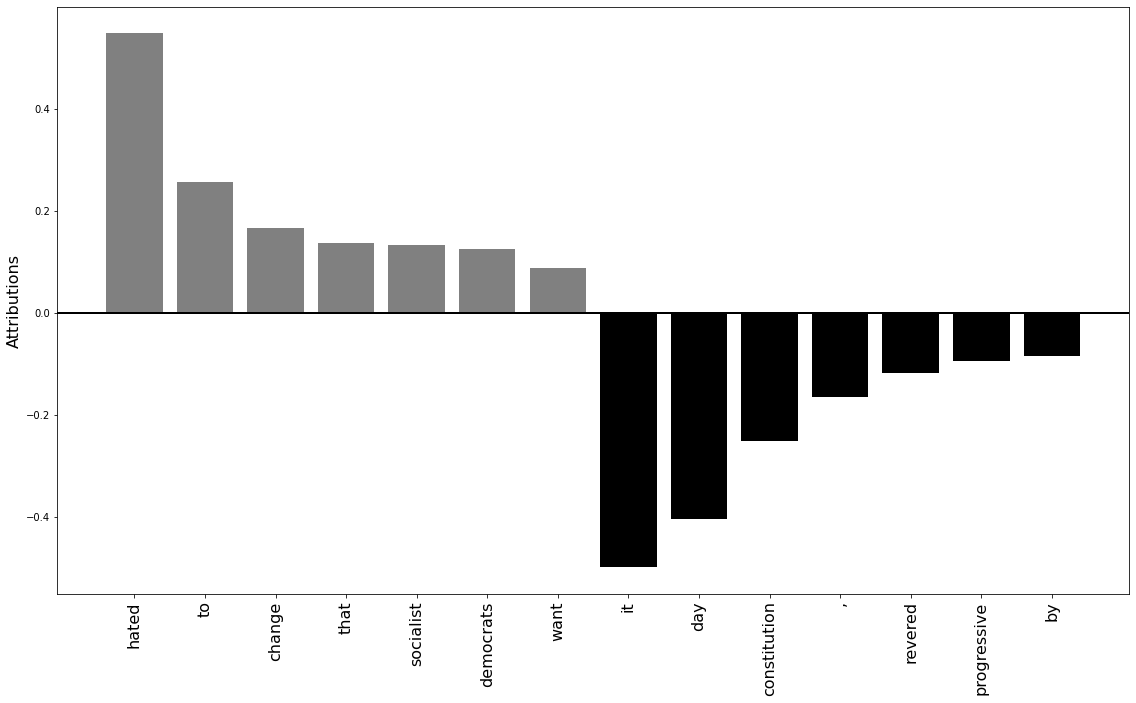

tweet: fox news nra maga potus trump 2 nd amendment rnc usmc veterans @user @user @user @user @user fake reporting theswamp dnc liberals @user @user fake outrage @user first , it reduces the ca url label: 0


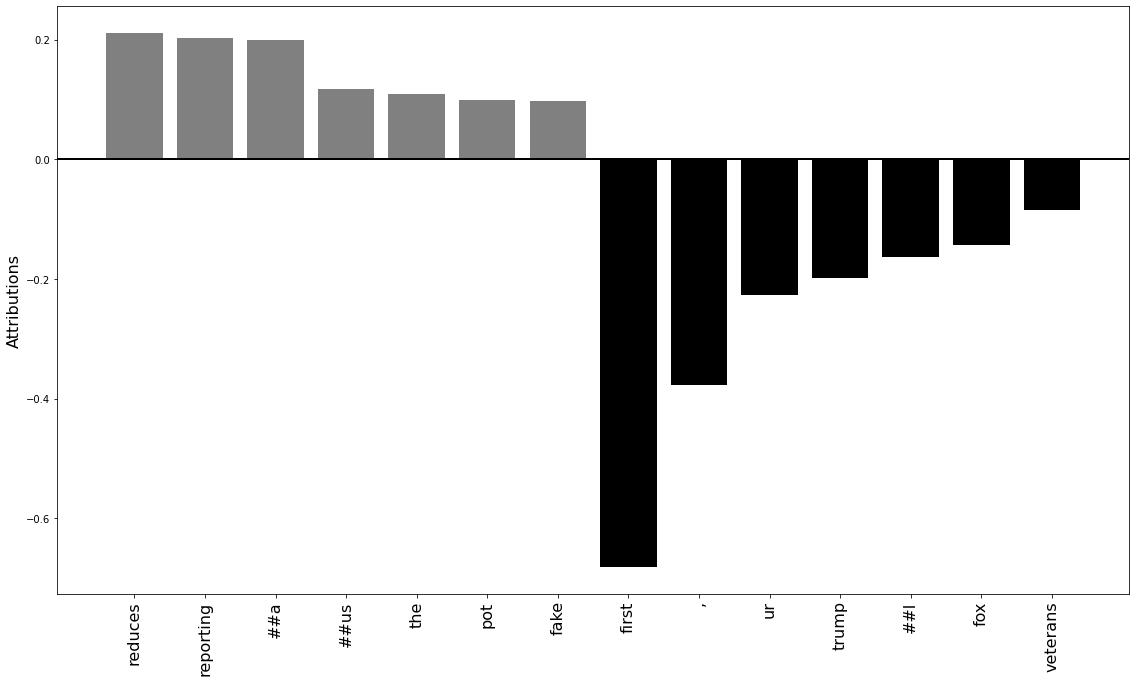

tweet: watching boomer getting the news that she is still up for parole always makes me smile . wentworth finale . . . @user is such a treasure . url label: 0


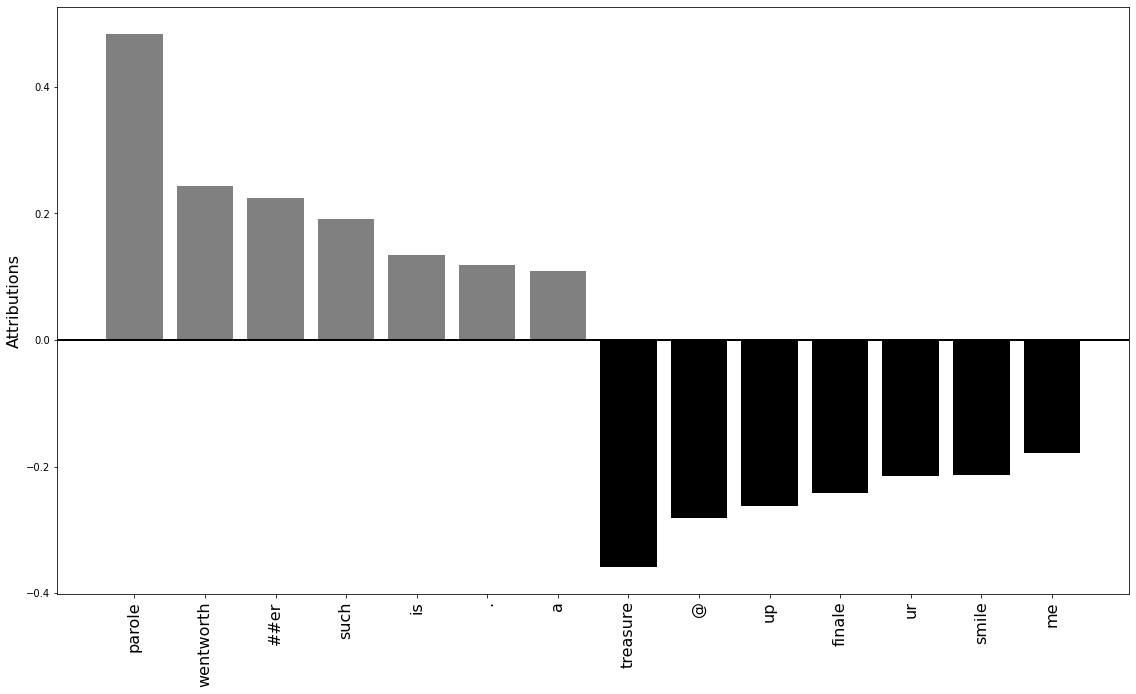

tweet: <number> tips to enhance audience connection on facebook url @user social media smm url label: 0


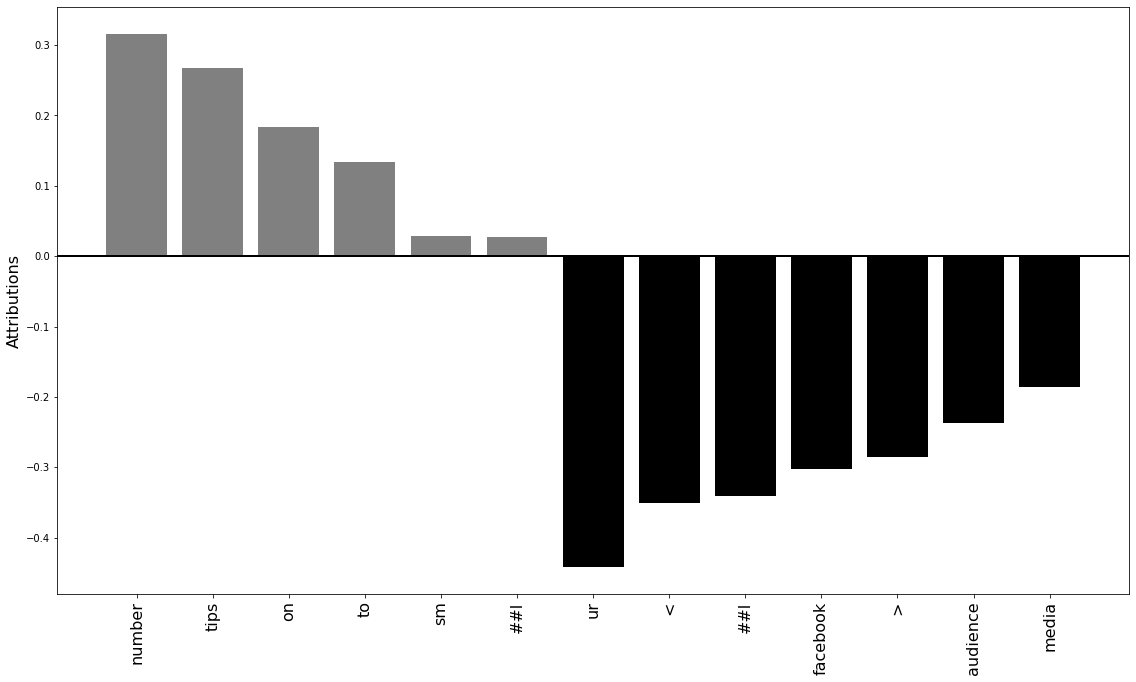

tweet: bigg boss tamil janani won the task . she is going to first final list label: 0


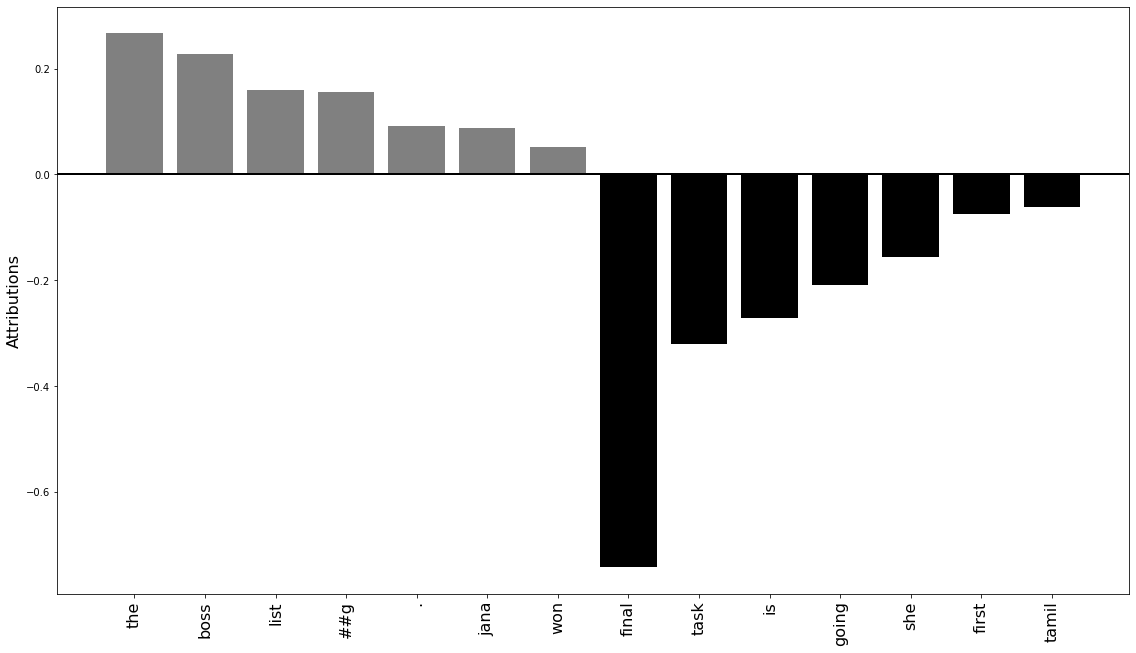

tweet: conservatives - the party of low taxation tories tory url label: 0


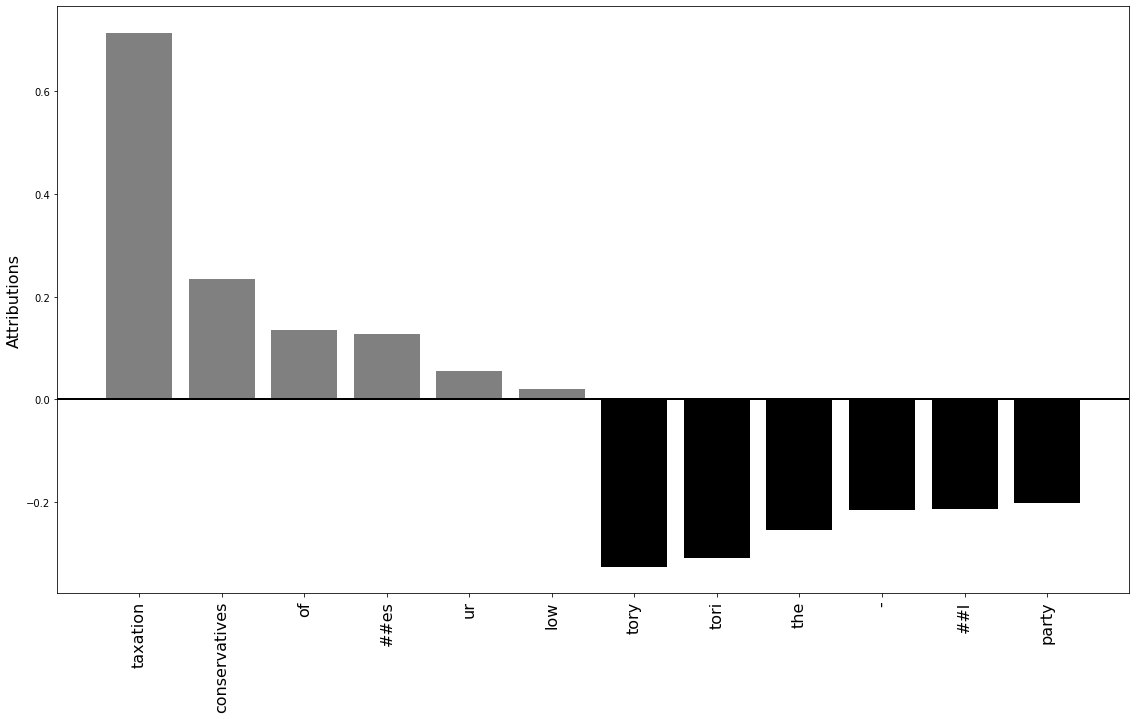

tweet: - . . the nord cannot make a single move , but he is fully aware of what is happening . a chill comes down his spine as a ghostly , rather . . . calm female voice called for him from a corner of the room . before he even has time to / attempt / a response , + label: 0


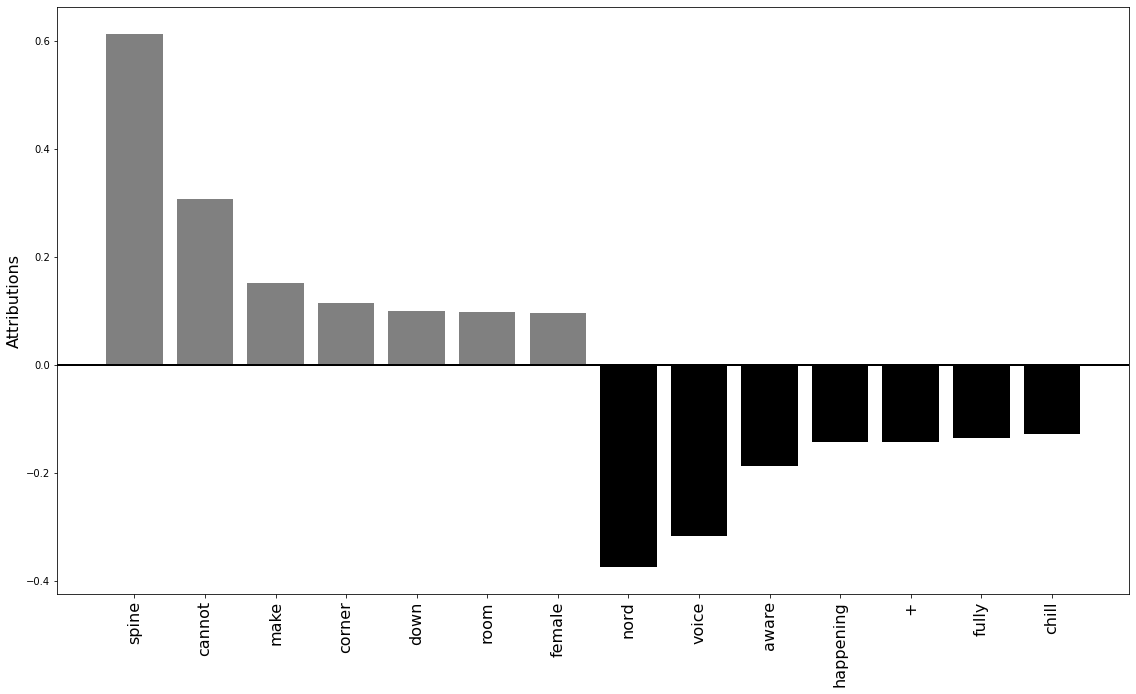

tweet: great awakening q anon patriots united wwg <number> wga are you awake when you are awake you see clearly check out this video url url label: 0


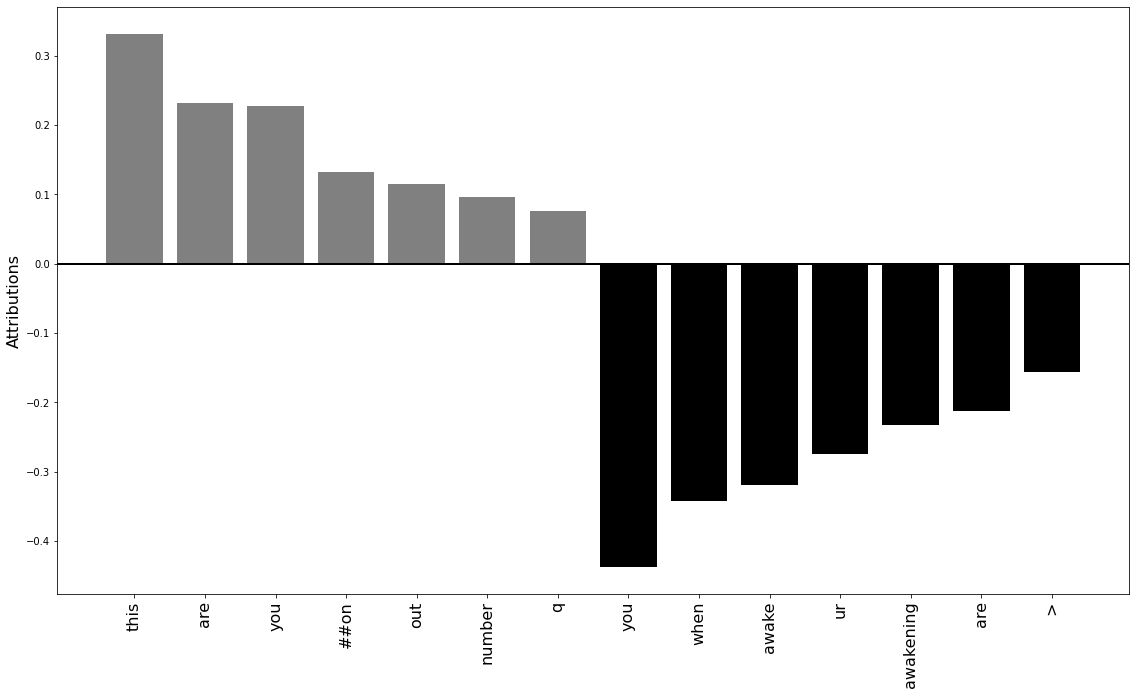

tweet: dayspromo week of <date> days dool a coma does things to a gal . sami : you are going to be ok . hattie : no thanks to you . get her out of here . before she finishes me off . hattie pretends to be marlena . the look on kayla face is priceless . url label: 0


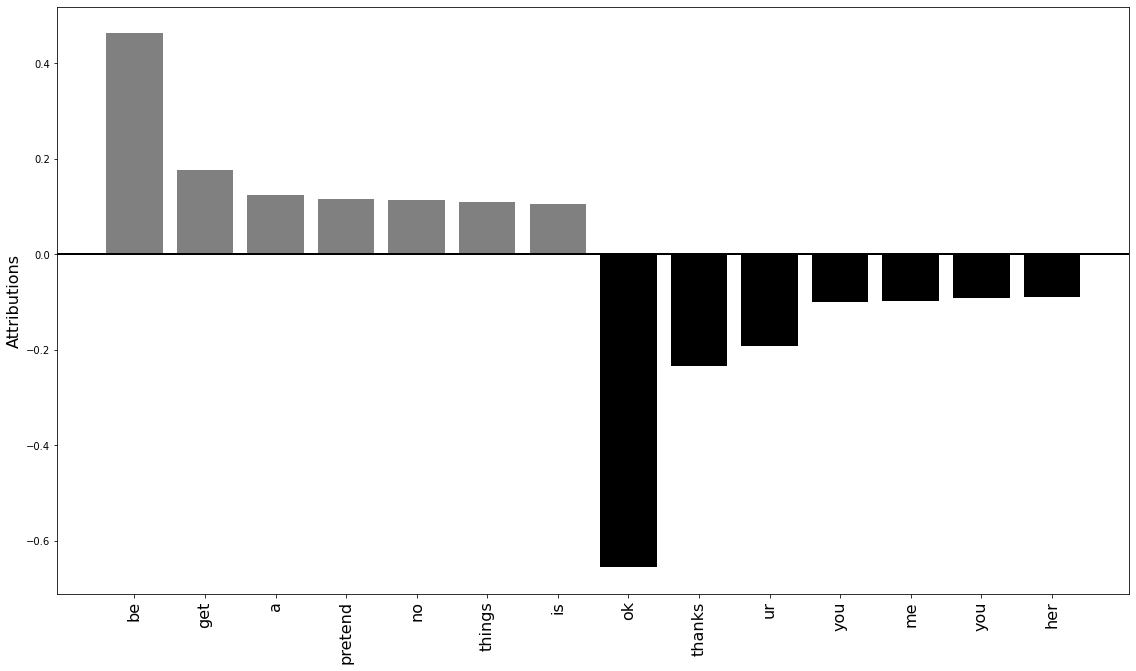

tweet: bigg boss telugu 2 let s all include @user in all our tweets . . . he is the business head of star maa network . . don t know if he knows about biggboss team and host hurting audience emotions bigg boss telugu 2 label: 0


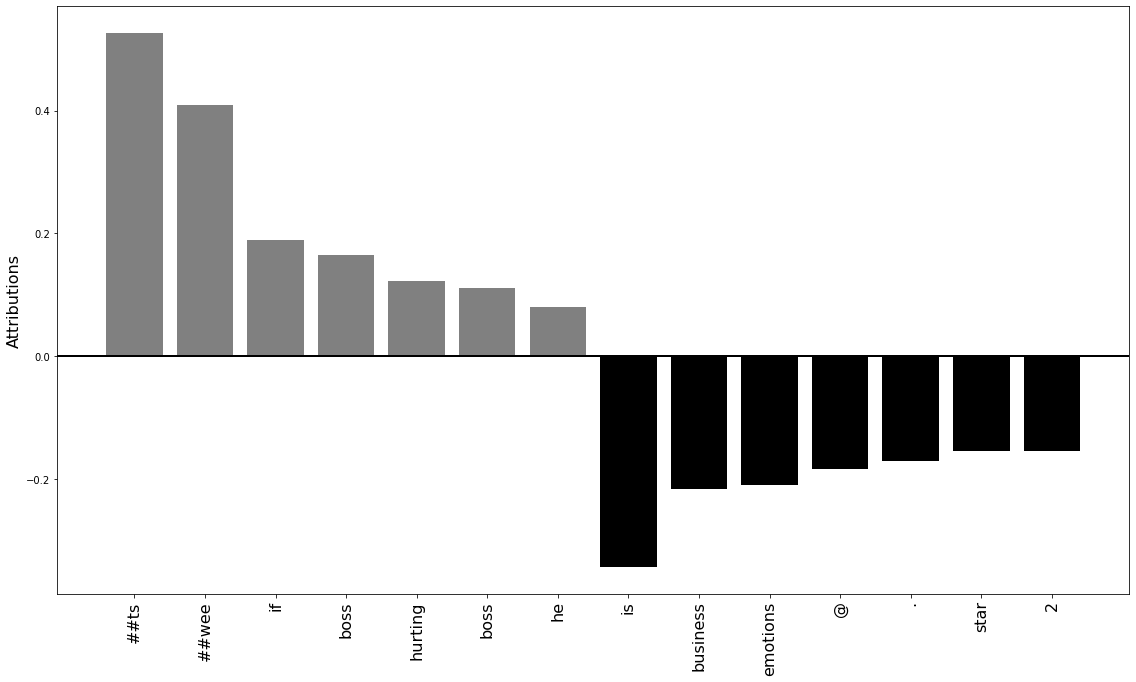

tweet: dallaspolicewoman kills neighbor in his own apartment ? what went wrong ? ? see : officer who shot man in his own apartment was involved in <number> shooting of a suspect . she is devastated , said a dallas police officer , adds she is " so so sorry for his family ? " url label: 0


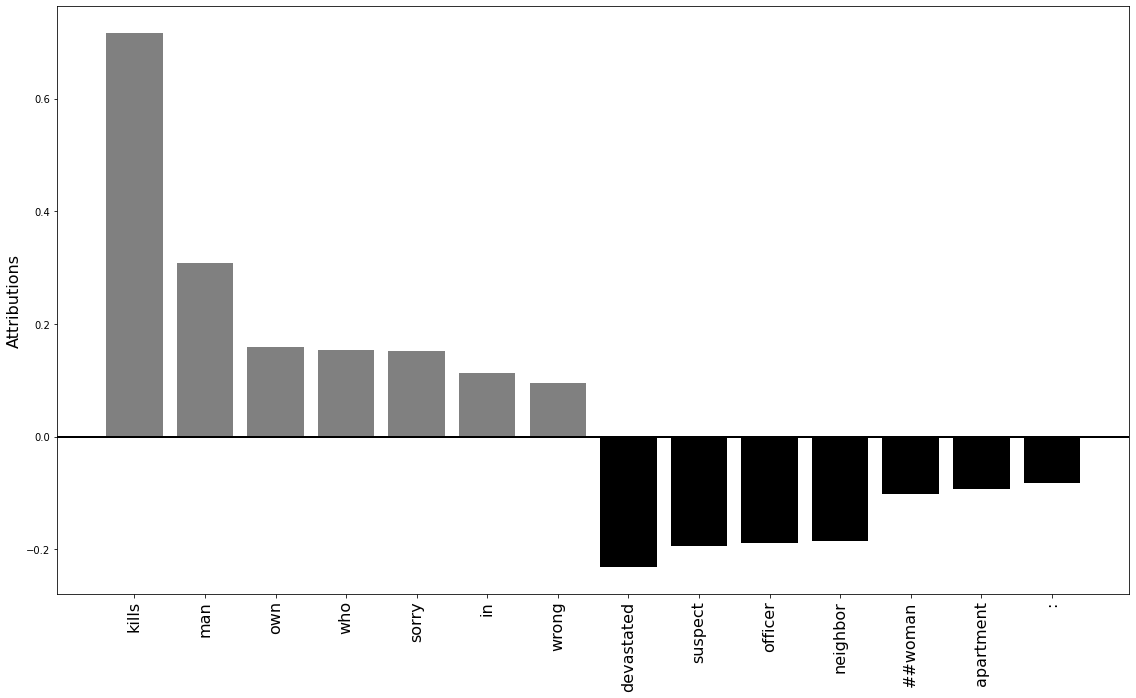

tweet: always smack url label: 0


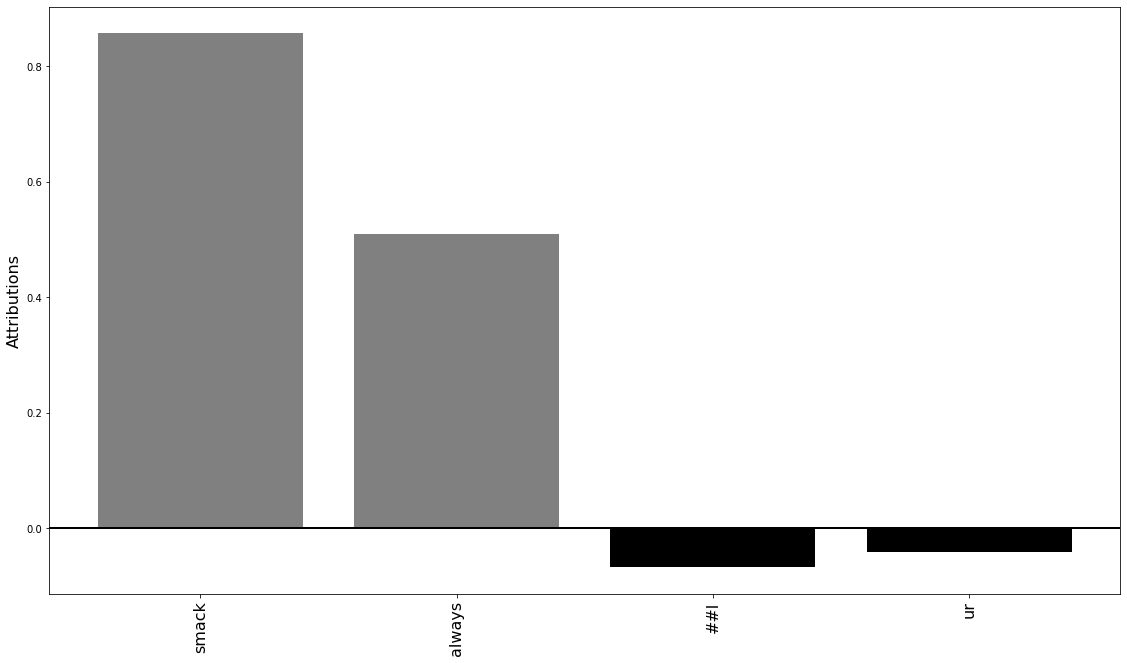

tweet: breaking : after a week - long trial , a linn county jury convicted gregory davis of first - degree murder in connection with the carrie davis homicide that took place almost a year ago . url url label: 0


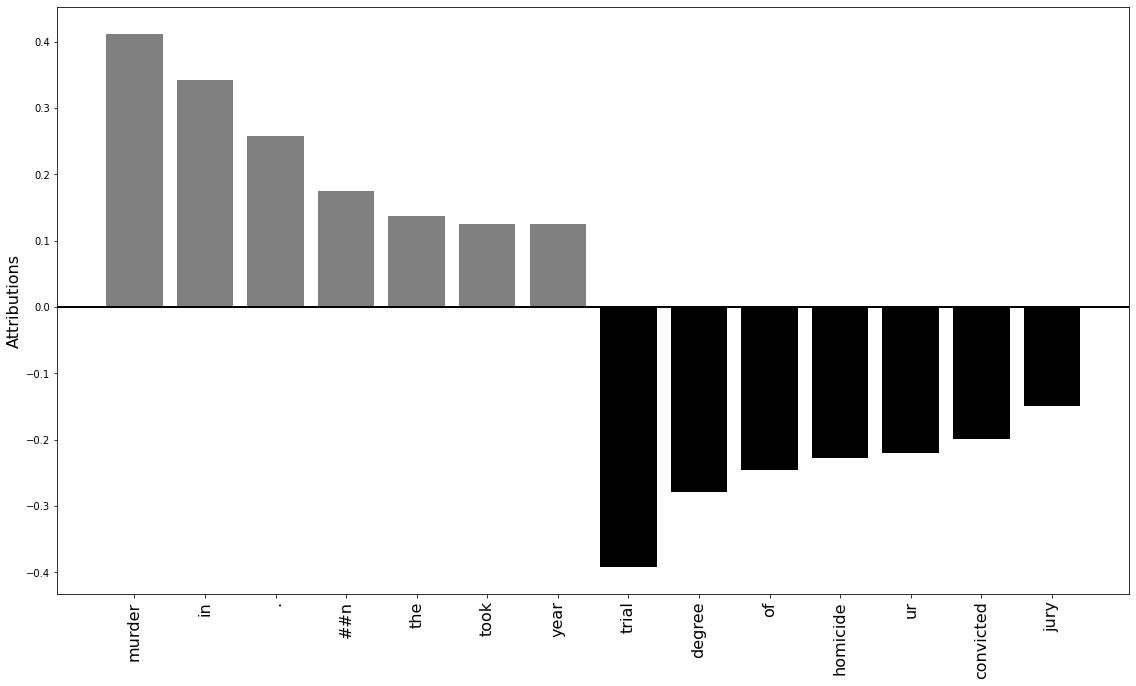

tweet: kavanaugh so a wild claim from <number> years ago of groping has evolved into a rape a violent sexual event by move url a soros based org . that supports blm antifa etc . unbeievable ! label: 0


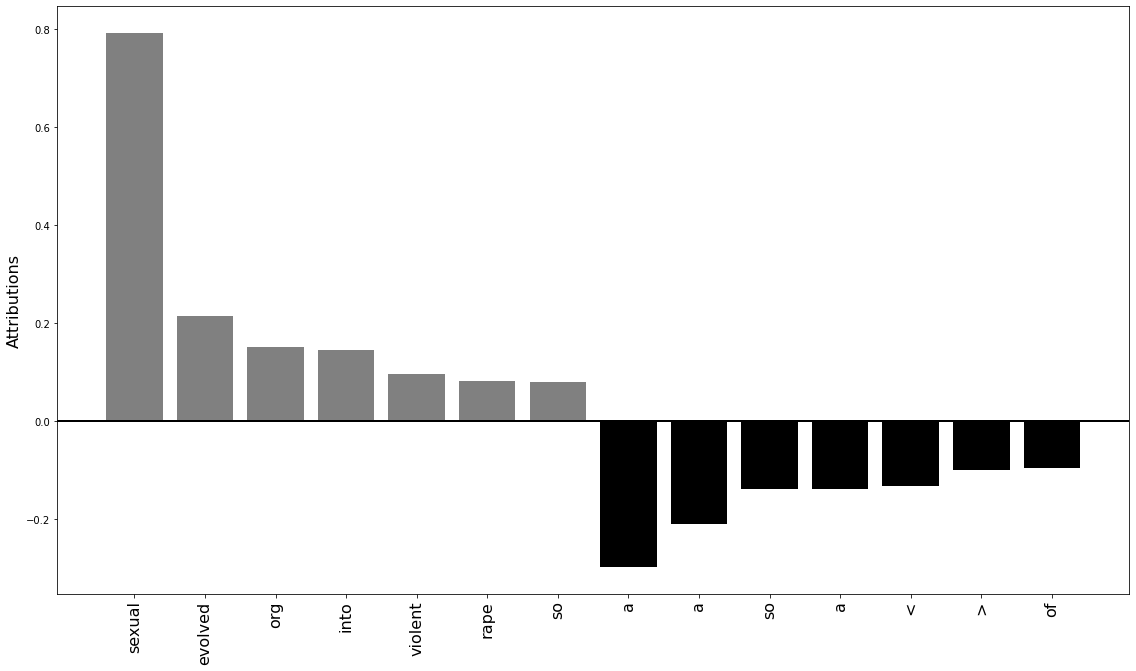

tweet: kzn lt enjouji really is the prototype of my character brand , he is nothing but things that i love all rolled into one horrible package and fed directly into baby me ' s subconscious . label: 0


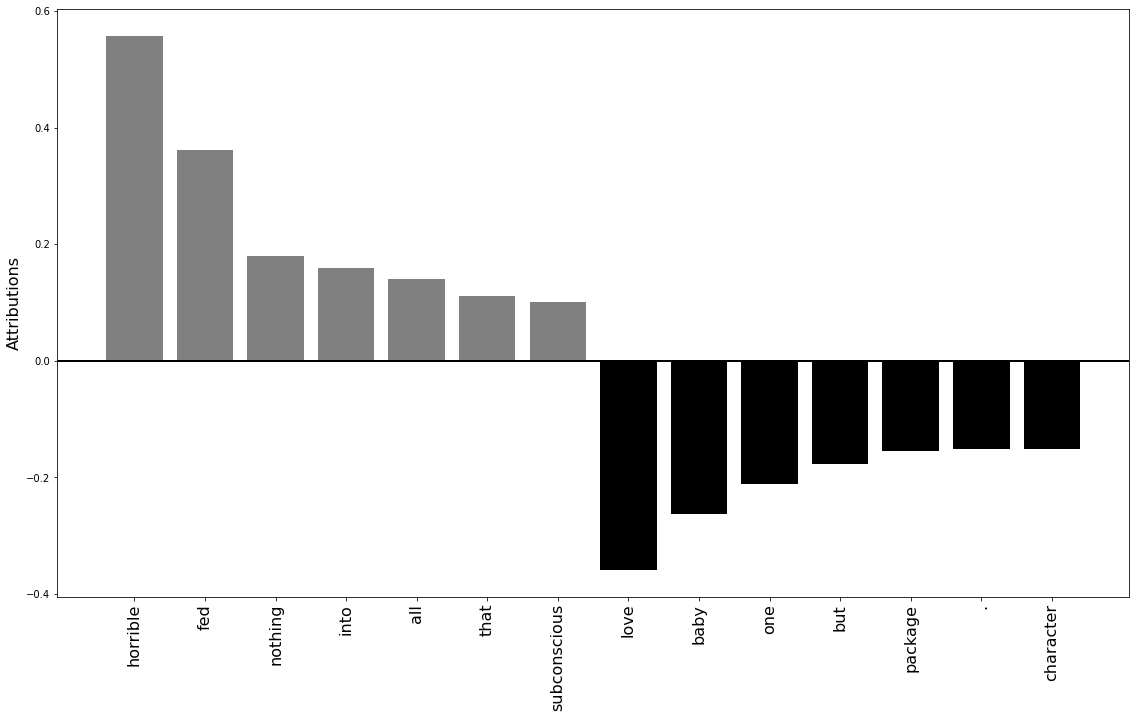

 Visualization For Score True negative predictions 


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.95),"constitution day is revered by conservatives , hated by progressives / socialist / democrats that want to change it .",-0.20,"[CLS] constitution day is revered by conservatives , hated by progressive ##s / socialist / democrats that want to change it . [SEP]"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.99),tips to enhance audience connection on facebook url @user social media smm url,-1.86,[CLS] < number > tips to enhance audience connection on facebook ur ##l @ user social media sm ##m ur ##l [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.99),bigg boss tamil janani won the task . she is going to first final list,-0.90,[CLS] big ##g boss tamil jana ##ni won the task . she is going to first final list [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.98),conservatives - the party of low taxation tories tory url,-0.23,[CLS] conservatives - the party of low taxation tori ##es tory ur ##l [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.58),always smack url,1.26,[CLS] always smack ur ##l [SEP]


In [27]:
def analyze_tweets(index_list, nr_of_tweets, title_of_prediction, pred_type):
  vis = []
  for i in range(nr_of_tweets):
    tweet, true_label = get_test_tweet_by_index(index_list[i])
    input_ids, ref_input_ids, sep_id, token_type_ids, ref_token_type_ids, position_ids, ref_position_ids, attention_mask, indices, all_tokens = tokenize_tweet(tweet)
    attributions, delta = get_attributions(input_ids, ref_input_ids)
    attributions_sum = summarize_attributions(attributions)
    score = predict(input_ids)
    vis.append(save_vis(attributions_sum, score, true_label, tweet, all_tokens, delta))
    n_attributions, n_tokens, nr_of_top_tokens = get_n_attributions_and_tokens(7, attributions_sum.detach().cpu().numpy(), np.array(all_tokens))
    plot_top_attributions(nr_of_top_tokens, n_attributions, n_tokens, 'Attributions',  '', pred_type + '_tweet_index_' + str(index_list[i]))

  print('\033[1m', 'Visualization For Score ' + title_of_prediction, '\033[0m')
  for i in range(nr_of_tweets):
    viz.visualize_text([vis[i]])

index_lists = [fp_indices, tp_indices, fn_indices, tn_indices]
prediction_titles = ['False positive predictions', 'True positive predictions', 'False negative predictions', 'True negative predictions']
pred_type = ['fp', 'tp', 'fn', 'tn']

for i_list, title, p_type in zip(index_lists, prediction_titles, pred_type):
  analyze_tweets(i_list, 15, title, p_type)

In [25]:
tweet, true_label = get_test_tweet_by_index(fp_indices[0])
input_ids, ref_input_ids, sep_id, token_type_ids, ref_token_type_ids, position_ids, ref_position_ids, attention_mask, indices, all_tokens = tokenize_tweet(tweet)
attributions, delta = get_attributions(input_ids, ref_input_ids)
attributions_sum = summarize_attributions(attributions)
attributions_sum = attributions_sum.detach().cpu().numpy()

tweet: rap is a form of art ! used to express yourself freely . it does not gv the green light or excuse the behavior of acting like an animal ! she is not in the streets of the bx where violence is a way of living . elevate yourself boo and get on @user level for longevity ! queen label: 0


rap is a form of art ! used to express yourself freely . it does not gv the green light or excuse the behavior of acting like an animal ! she is not in the streets of the bx where violence is a way of living . elevate yourself boo and get on @user level for longevity ! queen


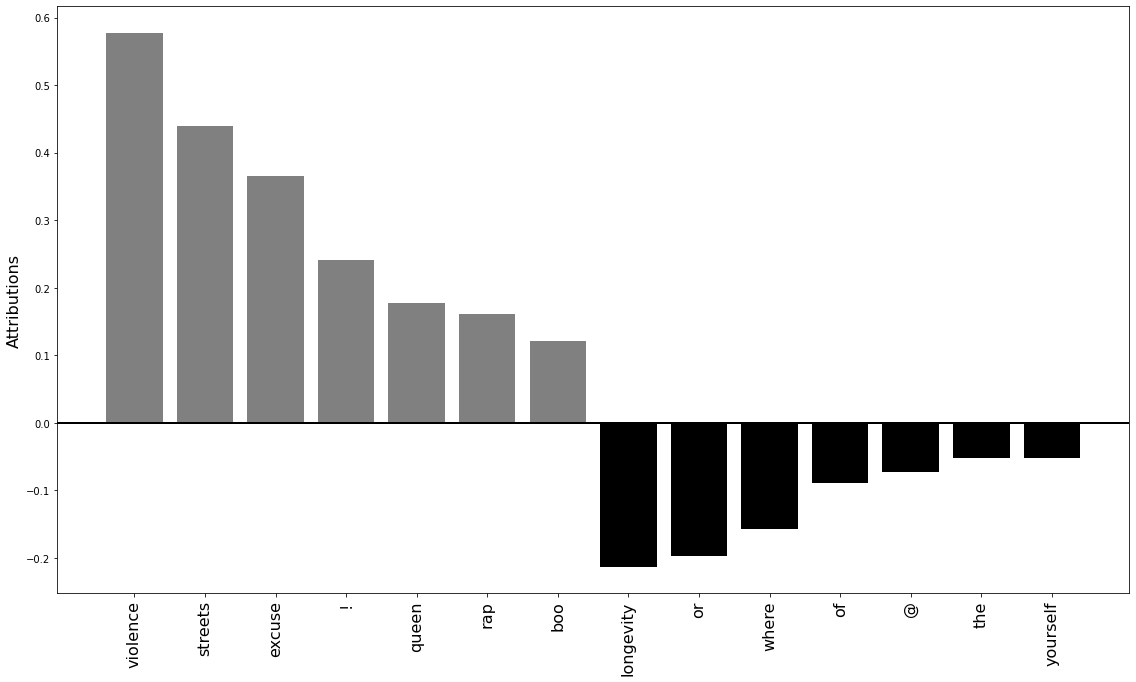

In [38]:
n_attributions, n_tokens = get_n_attributions_and_tokens(7, attributions_sum, np.array(all_tokens))
print(tweet)
plot_top_attributions(7, n_attributions, n_tokens, 'Attributions',  '', 'test_plot_tweet_index_' + str(fp_indices[0]))